# Diff Classifier Training

In [1]:
from src.data.ParkingProvider import NoSpacesException, NoImageException
from src.metrics.PerformanceMetricsProviderSklearn import PerformanceMetricsProviderSklearn
from src.metrics.entity.PerformanceMetrics import PerformanceMetrics
from src.detector.entity.DetectionParams import DetectionParams
from src.data.ParkingProviderLocal import ParkingProviderLocalParams,ParkingProviderLocal
from src.app.ParkingOccupancyProcessorLocal import ParkingOccupancyProcessorLocal
from src.detector.OccupancyDetectorDiff import OccupancyDetectorDiff
import pandas as pd
import cv2 as cv
import os
import pickle

# metrics_list = list()
# row_names = list()
random_seed = 1
# random_seed = datetime.now().timestamp
 
def test_parking(parking_id, weather, detection_params:DetectionParams, process_batch=True, training=False):
    metrics_provider: PerformanceMetricsProviderSklearn = PerformanceMetricsProviderSklearn()

    training_test_folder = 'training' if training else 'test'
    provider_params = ParkingProviderLocalParams(
    parking_id=parking_id, path=f'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\dataset\\{training_test_folder}\\{parking_id}\\{weather}')
    
    processor = ParkingOccupancyProcessorLocal(
        parking_provider_params=provider_params, detection_params=detection_params, performance_metrics_provider=metrics_provider)

    detection_params.parking_id = parking_id
    detection_params.weather = weather
    
    if process_batch:
        if training:
            try:
                return processor.process_batch_training(10)
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing training samples: ", ex)
        else:
            try:
                detection_params.show_imshow=False
                processor.process_batch(10)
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)

    else:
        while True:
            try:
                detection_params.show_imshow=True
                processor.process()
            except (NoSpacesException, NoImageException) as ex:
                print(f"Finished processing samples: ", ex)
                break
        
    metrics_provider.calculate_metrics()
    plot = not training
    metrics_provider.show_confusion_matrix(plot)

    return metrics_provider.metrics
    # metrics_list.append(metrics_provider.metrics)
    # row_names.append(row_name)
    
def test_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_threshold_list, vacant_threshold_list, training=False):
    detection_params.weather = weather
    metrics_dict = dict()
    
    for vacant_threshold in vacant_threshold_list:
        metrics_dict_diff = dict()
        
        for diff_threshold in diff_threshold_list:    
            row_name = f'{parking_id}-{weather} vt={vacant_threshold} diff_t={diff_threshold}'
            print('Testing ', row_name)
            
            detection_params.vacant_threshold = vacant_threshold
            detection_params.diff_threshold = diff_threshold
            metrics = test_parking(parking_id, weather, detection_params, row_name, True, training)
            
            metrics_dict_diff[diff_threshold] = metrics

        metrics_dict[vacant_threshold] = metrics_dict_diff
         
    return metrics_dict
        


def training_vacant_threshold(parking_id, weather, detection_params:DetectionParams, diff_list):
    detection_params.weather = weather
    metrics_dict_diff = dict()
        
    for diff in diff_list:    
        row_name = f'Training {parking_id}-{weather} diff={diff}'
        print('Testing ', row_name)
        detection_params.diff_threshold = diff
        metrics = test_parking(parking_id, weather, detection_params, True, training=True)
        
        metrics_dict_diff[diff] = metrics
 
    return metrics_dict_diff

def calculate_metrics(parking_id, weather_list, diff_list,  params=DetectionParams(), training=True, show_metrics=True, save_fig_dst=None):
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:
        
        file_pickle = f"test/diffDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"
        if not os.path.exists(file_pickle):
            metrics_diff_dict = training_vacant_threshold(parking_id, weather, params, diff_list)
        else:
            with open(file_pickle, 'rb') as f:
                print(file_pickle)
                metrics_diff_dict = pickle.load(f)
                
        # Saving the objects:   
        if not os.path.exists(file_pickle):
            f= open(file_pickle, 'wb')
            pickle.dump(metrics_diff_dict, f)


        if show_metrics and save_fig_dst is not None :
            fig_dst = save_fig_dst + f'{parking_id}_{weather}_{training_test_folder}.png'
            PerformanceMetricsProviderSklearn.show_tpr_fpr(metrics_diff_dict, show_diff=False, save_fig_dst=fig_dst, first_param_str="diff")

def choose_training_parameters(parking_id) -> pd.DataFrame:
    weather_dict = dict()
    weather_list = ['Sunny', 'Cloudy', 'Rainy']
    training = True
    training_test_folder = 'training' if training else 'test'

    for weather in weather_list:

        file_pickle = f"test/diffDetector/metrics_dict_vt_{parking_id}_{weather}_{training_test_folder}.pickle"

        with open(file_pickle, 'rb') as f:
            print(file_pickle)
            metrics_dict_vt = pickle.load(f)
            
            weather_dict[weather] = metrics_dict_vt
            
    df = PerformanceMetricsProviderSklearn.choose_parameters(weather_dict, "diff")
    df[['AUC', 'Dist',  "Precision", "Specificity", "Recall", "F1", "Accuracy"]] = df[['AUC', 'Dist',  "Precision", "Specificity", "Recall", "F1", "Accuracy"]].round(3)

    pd.set_option('display.max_rows', None)

    display(df)
    # Seleccionar fila con mayor F1 para cada weather
    best_rows = df.loc[df.groupby("Weather")["F1"].idxmax()]
    best_rows['Weather'] = pd.Categorical(best_rows['Weather'], ['Sunny', 'Cloudy', 'Rainy'], ordered=True)
    best_rows = best_rows.sort_values(by=['Weather'])
    # Seleccionar la mejor fila global
    # global_best_row = df.loc[df["F1"].idxmax()]

    print("Mejor fila por weather:")
    print(best_rows)
    # print("\nMejor fila global:")
    # print(global_best_row)
    
    return df


def training_parking(parking_id):
    diff_threshold_list = [30,35,40,45,50,55]
    weather_list = ['Sunny', 'Cloudy', 'Rainy']
    training = True
    save_dst = 'E:\\OneDrive - UNIVERSIDAD DE HUELVA\\TFG\\VisionParkDetect\\test\\diffDetector\\'
    params = DetectionParams()
    params.match_histograms = True


    training_test_folder = 'training' if training else 'test'
    calculate_metrics(parking_id, weather_list, diff_threshold_list, params=params, training=training, show_metrics=True, save_fig_dst=save_dst)
    
def test_parking_diff_vt(parking_id, diff_threshold, vacant_threshold, weather_list = ['Sunny', 'Cloudy', 'Rainy']):
    training = False
    training_str = 'Training' if training else 'Testing'
    detection_params=DetectionParams()
    detection_params.diff_threshold = diff_threshold
    detection_params.vacant_threshold = vacant_threshold
    detection_params.match_histograms = True

    
    testing_metrics = dict()

    for weather in weather_list:
        row_name = f'{weather}-{training_str} bs={detection_params.diff_threshold} vt={detection_params.vacant_threshold}'
        print(row_name)
        testing_metrics[row_name]=test_parking(parking_id, weather, detection_params=detection_params, process_batch=True, training=training)
        print(testing_metrics[row_name].to_latex("Test", weather, detection_params.diff_threshold, detection_params.vacant_threshold))

    
# def transpose_dict(dictionary):
#     transposed_dict = {}
#     for vacant_threshold, inner_dict in dictionary.items():
#         for block_size, metrics in inner_dict.items():
#             if block_size not in transposed_dict:
#                 transposed_dict[block_size] = {}
#             transposed_dict[block_size][vacant_threshold] = metrics
#     return transposed_dict


## UFPR04

### UFPR04 Training

test/diffDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle


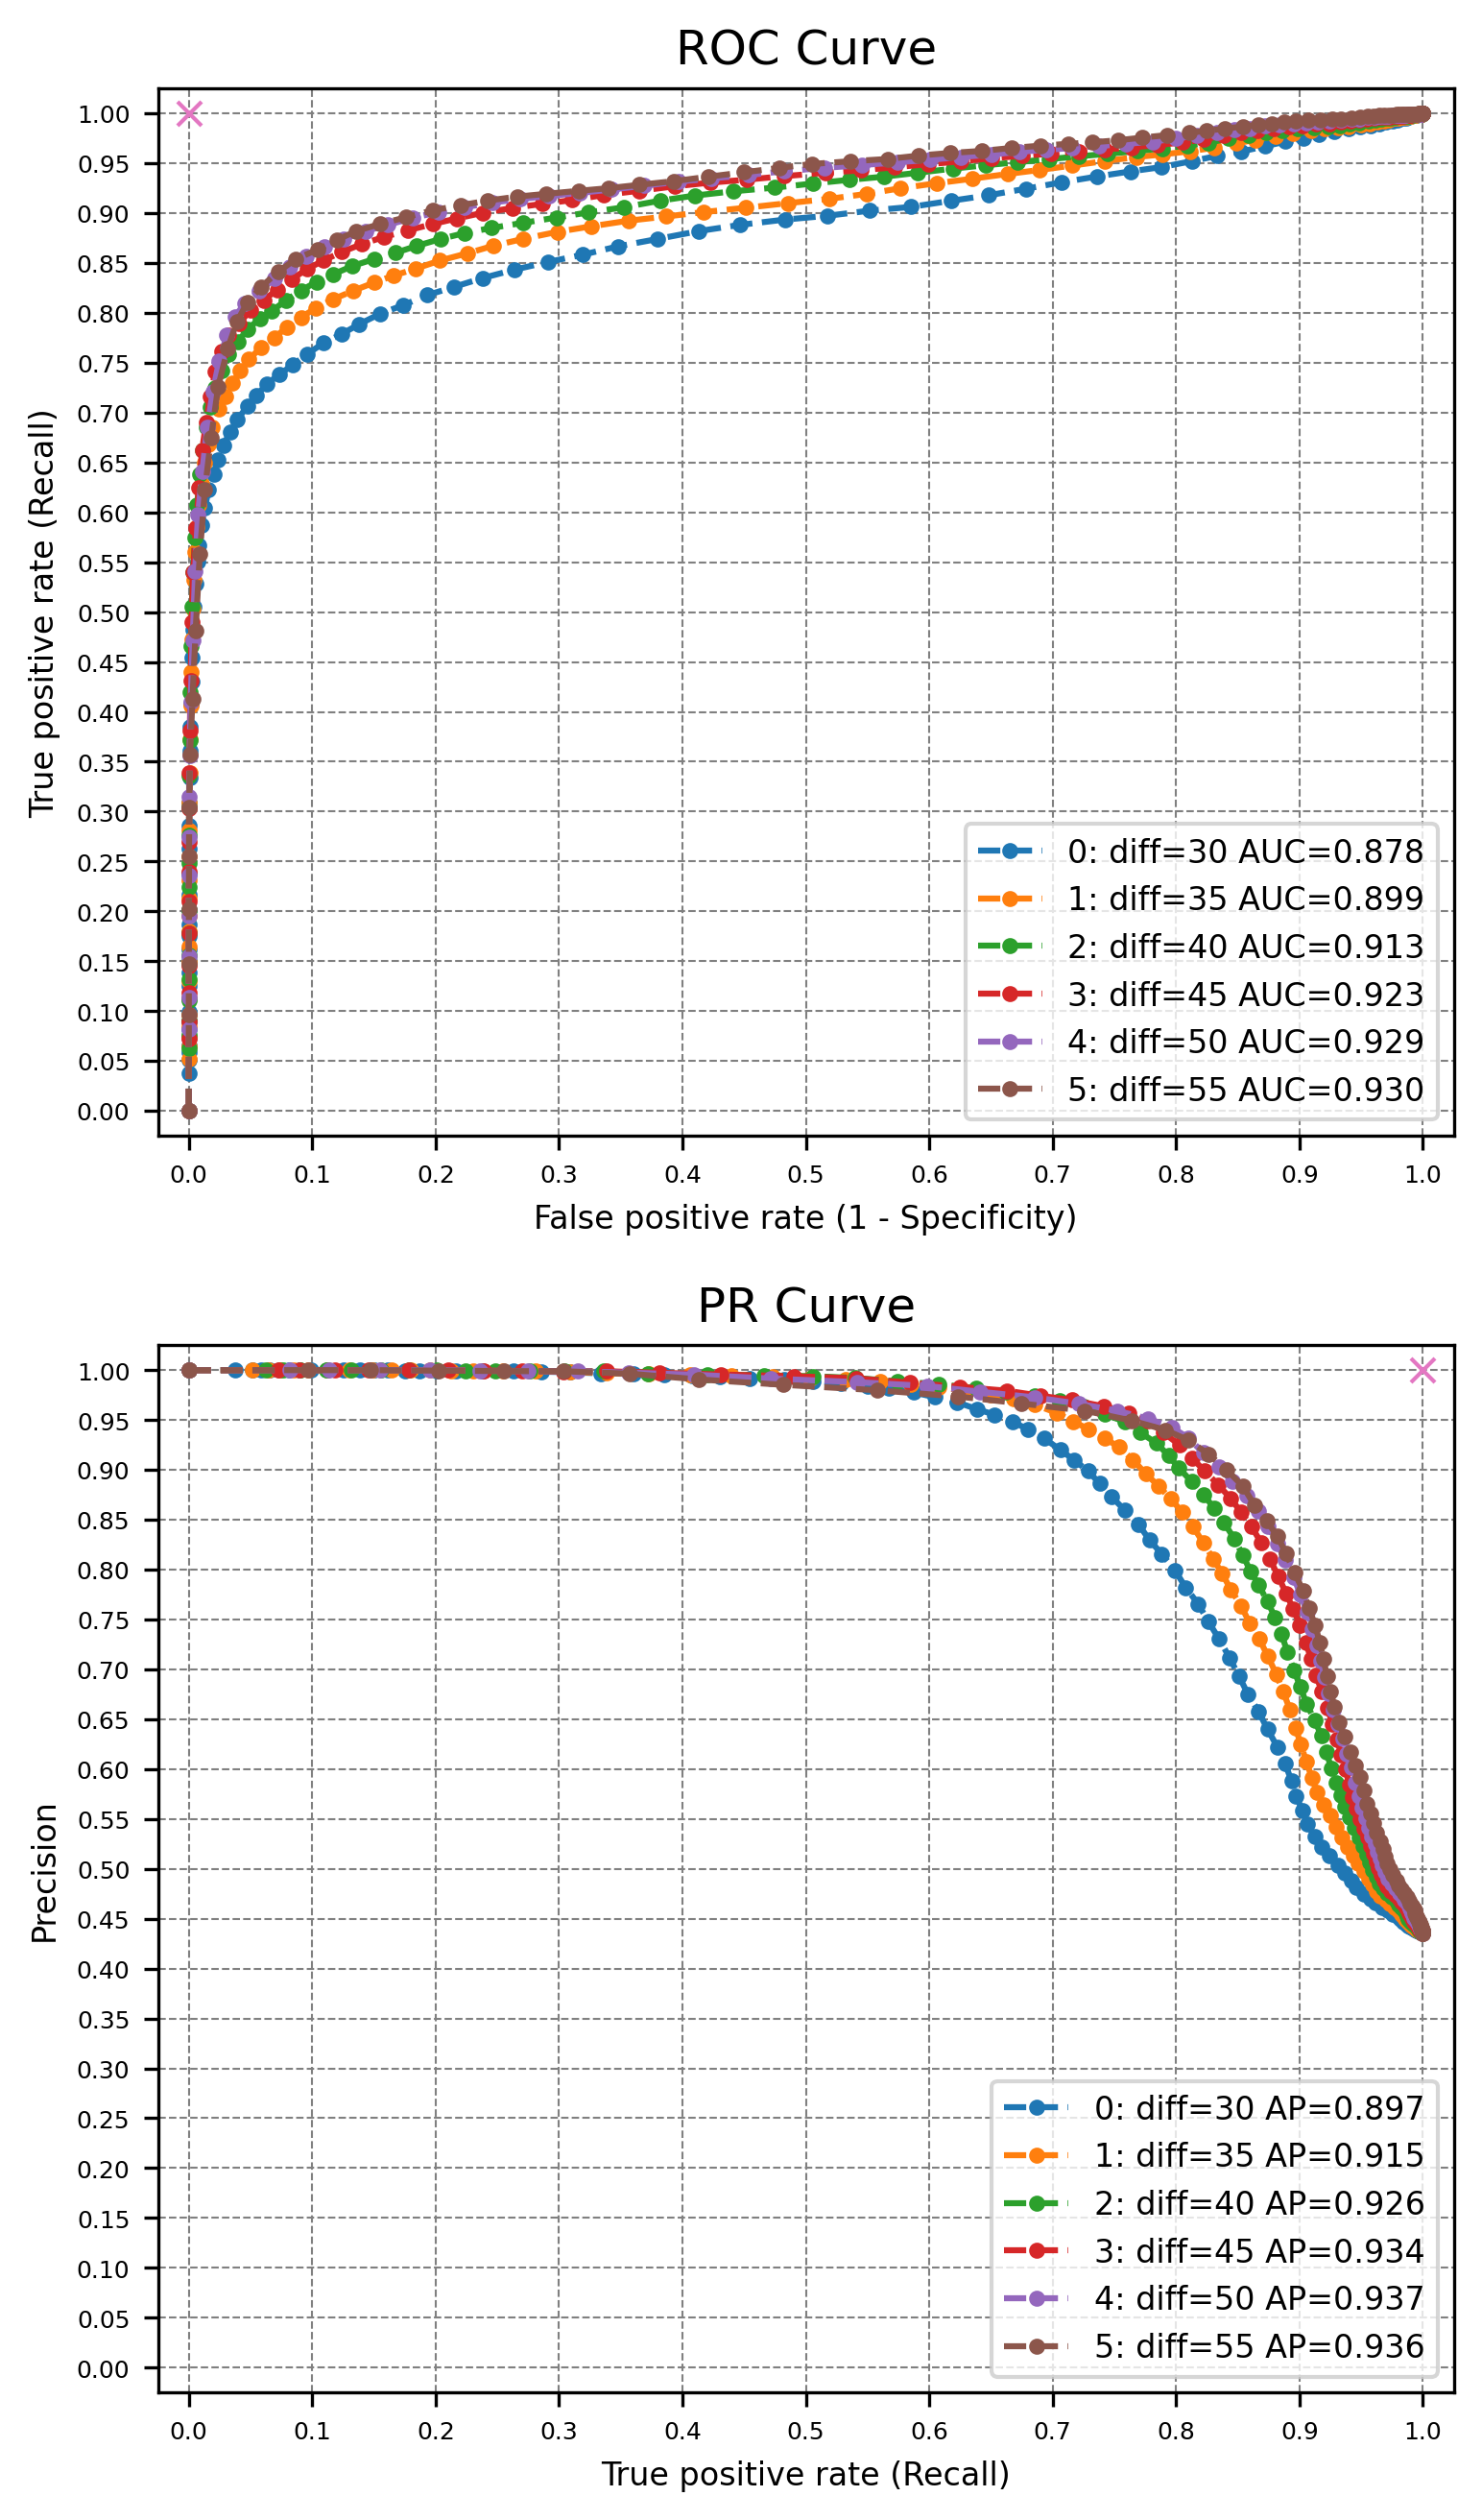

Testing  Training UFPR04-Cloudy diff=30
Using OccupancyDetectorDiff
Selected 1120 files
Processing 1120 files with 10 workers


100%|██████████| 1120/1120 [00:35<00:00, 31.18it/s]


Testing  Training UFPR04-Cloudy diff=35
Using OccupancyDetectorDiff
Selected 1120 files
Processing 1120 files with 10 workers


100%|██████████| 1120/1120 [00:36<00:00, 30.38it/s]


Testing  Training UFPR04-Cloudy diff=40
Using OccupancyDetectorDiff
Selected 1120 files
Processing 1120 files with 10 workers


100%|██████████| 1120/1120 [00:36<00:00, 30.46it/s]


Testing  Training UFPR04-Cloudy diff=45
Using OccupancyDetectorDiff
Selected 1120 files
Processing 1120 files with 10 workers


100%|██████████| 1120/1120 [00:36<00:00, 30.63it/s]


Testing  Training UFPR04-Cloudy diff=50
Using OccupancyDetectorDiff
Selected 1120 files
Processing 1120 files with 10 workers


100%|██████████| 1120/1120 [00:36<00:00, 31.06it/s]


Testing  Training UFPR04-Cloudy diff=55
Using OccupancyDetectorDiff
Selected 1120 files
Processing 1120 files with 10 workers


100%|██████████| 1120/1120 [00:36<00:00, 31.03it/s]


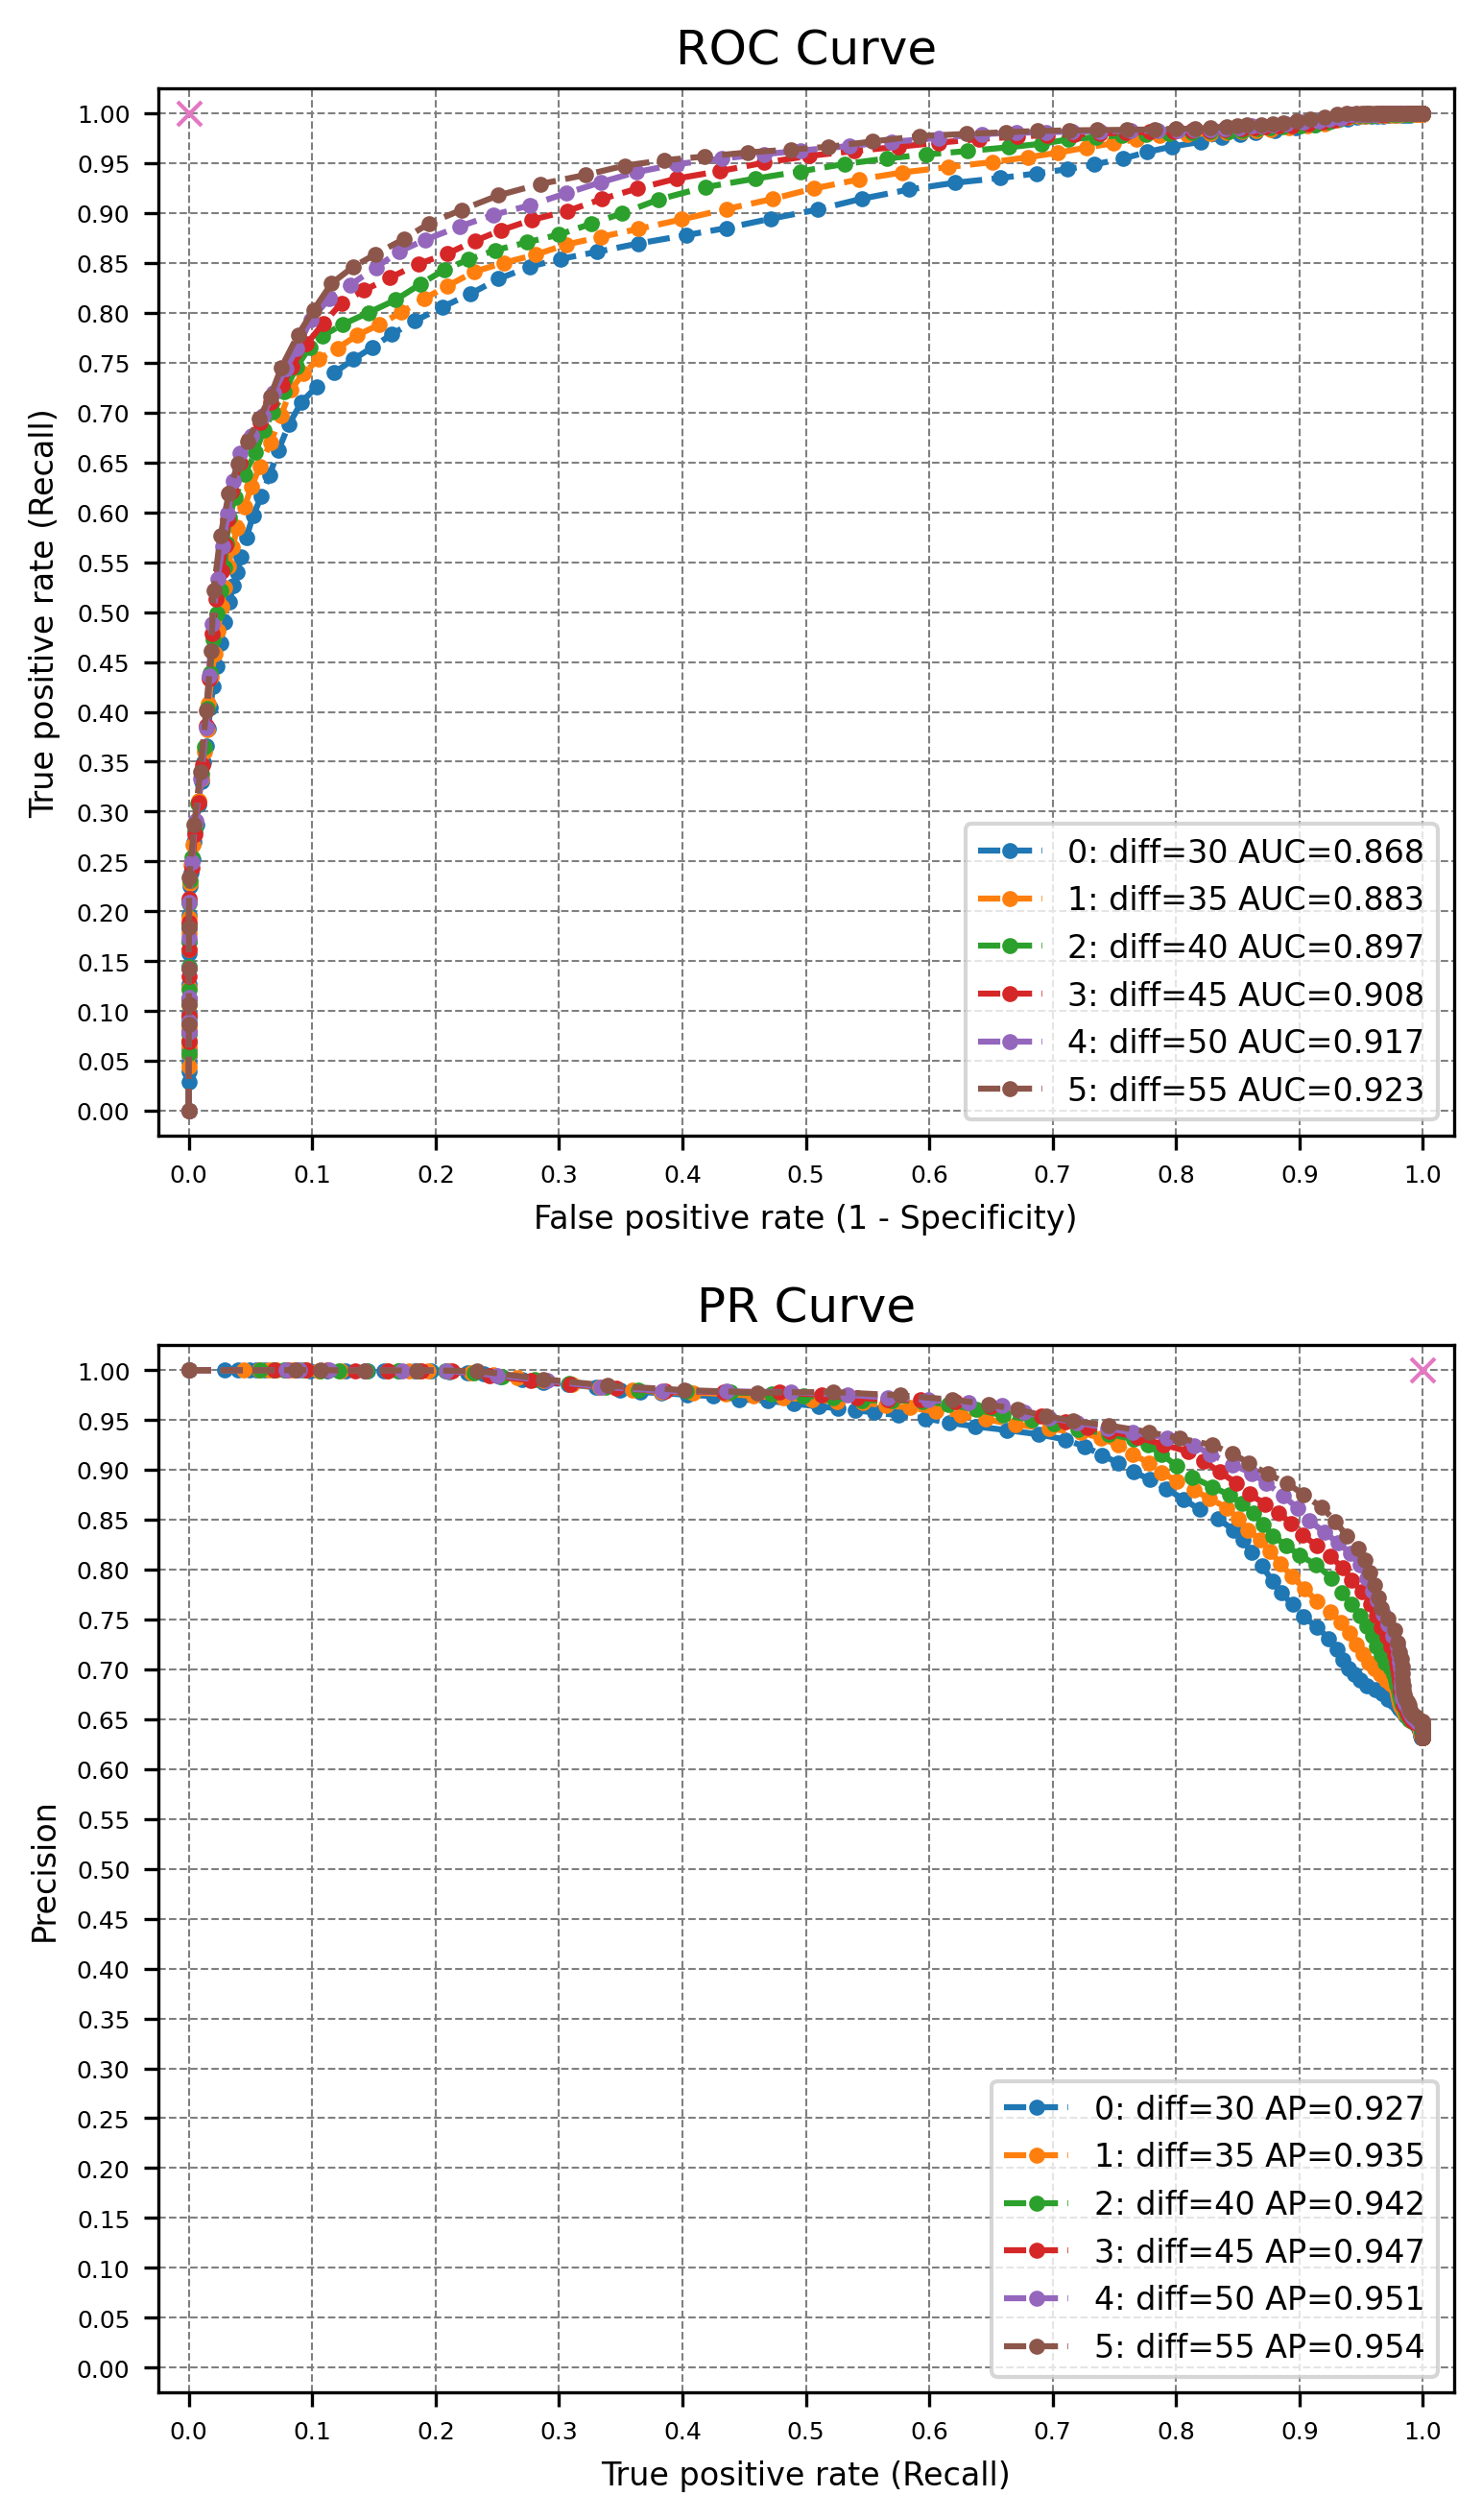

test/diffDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle


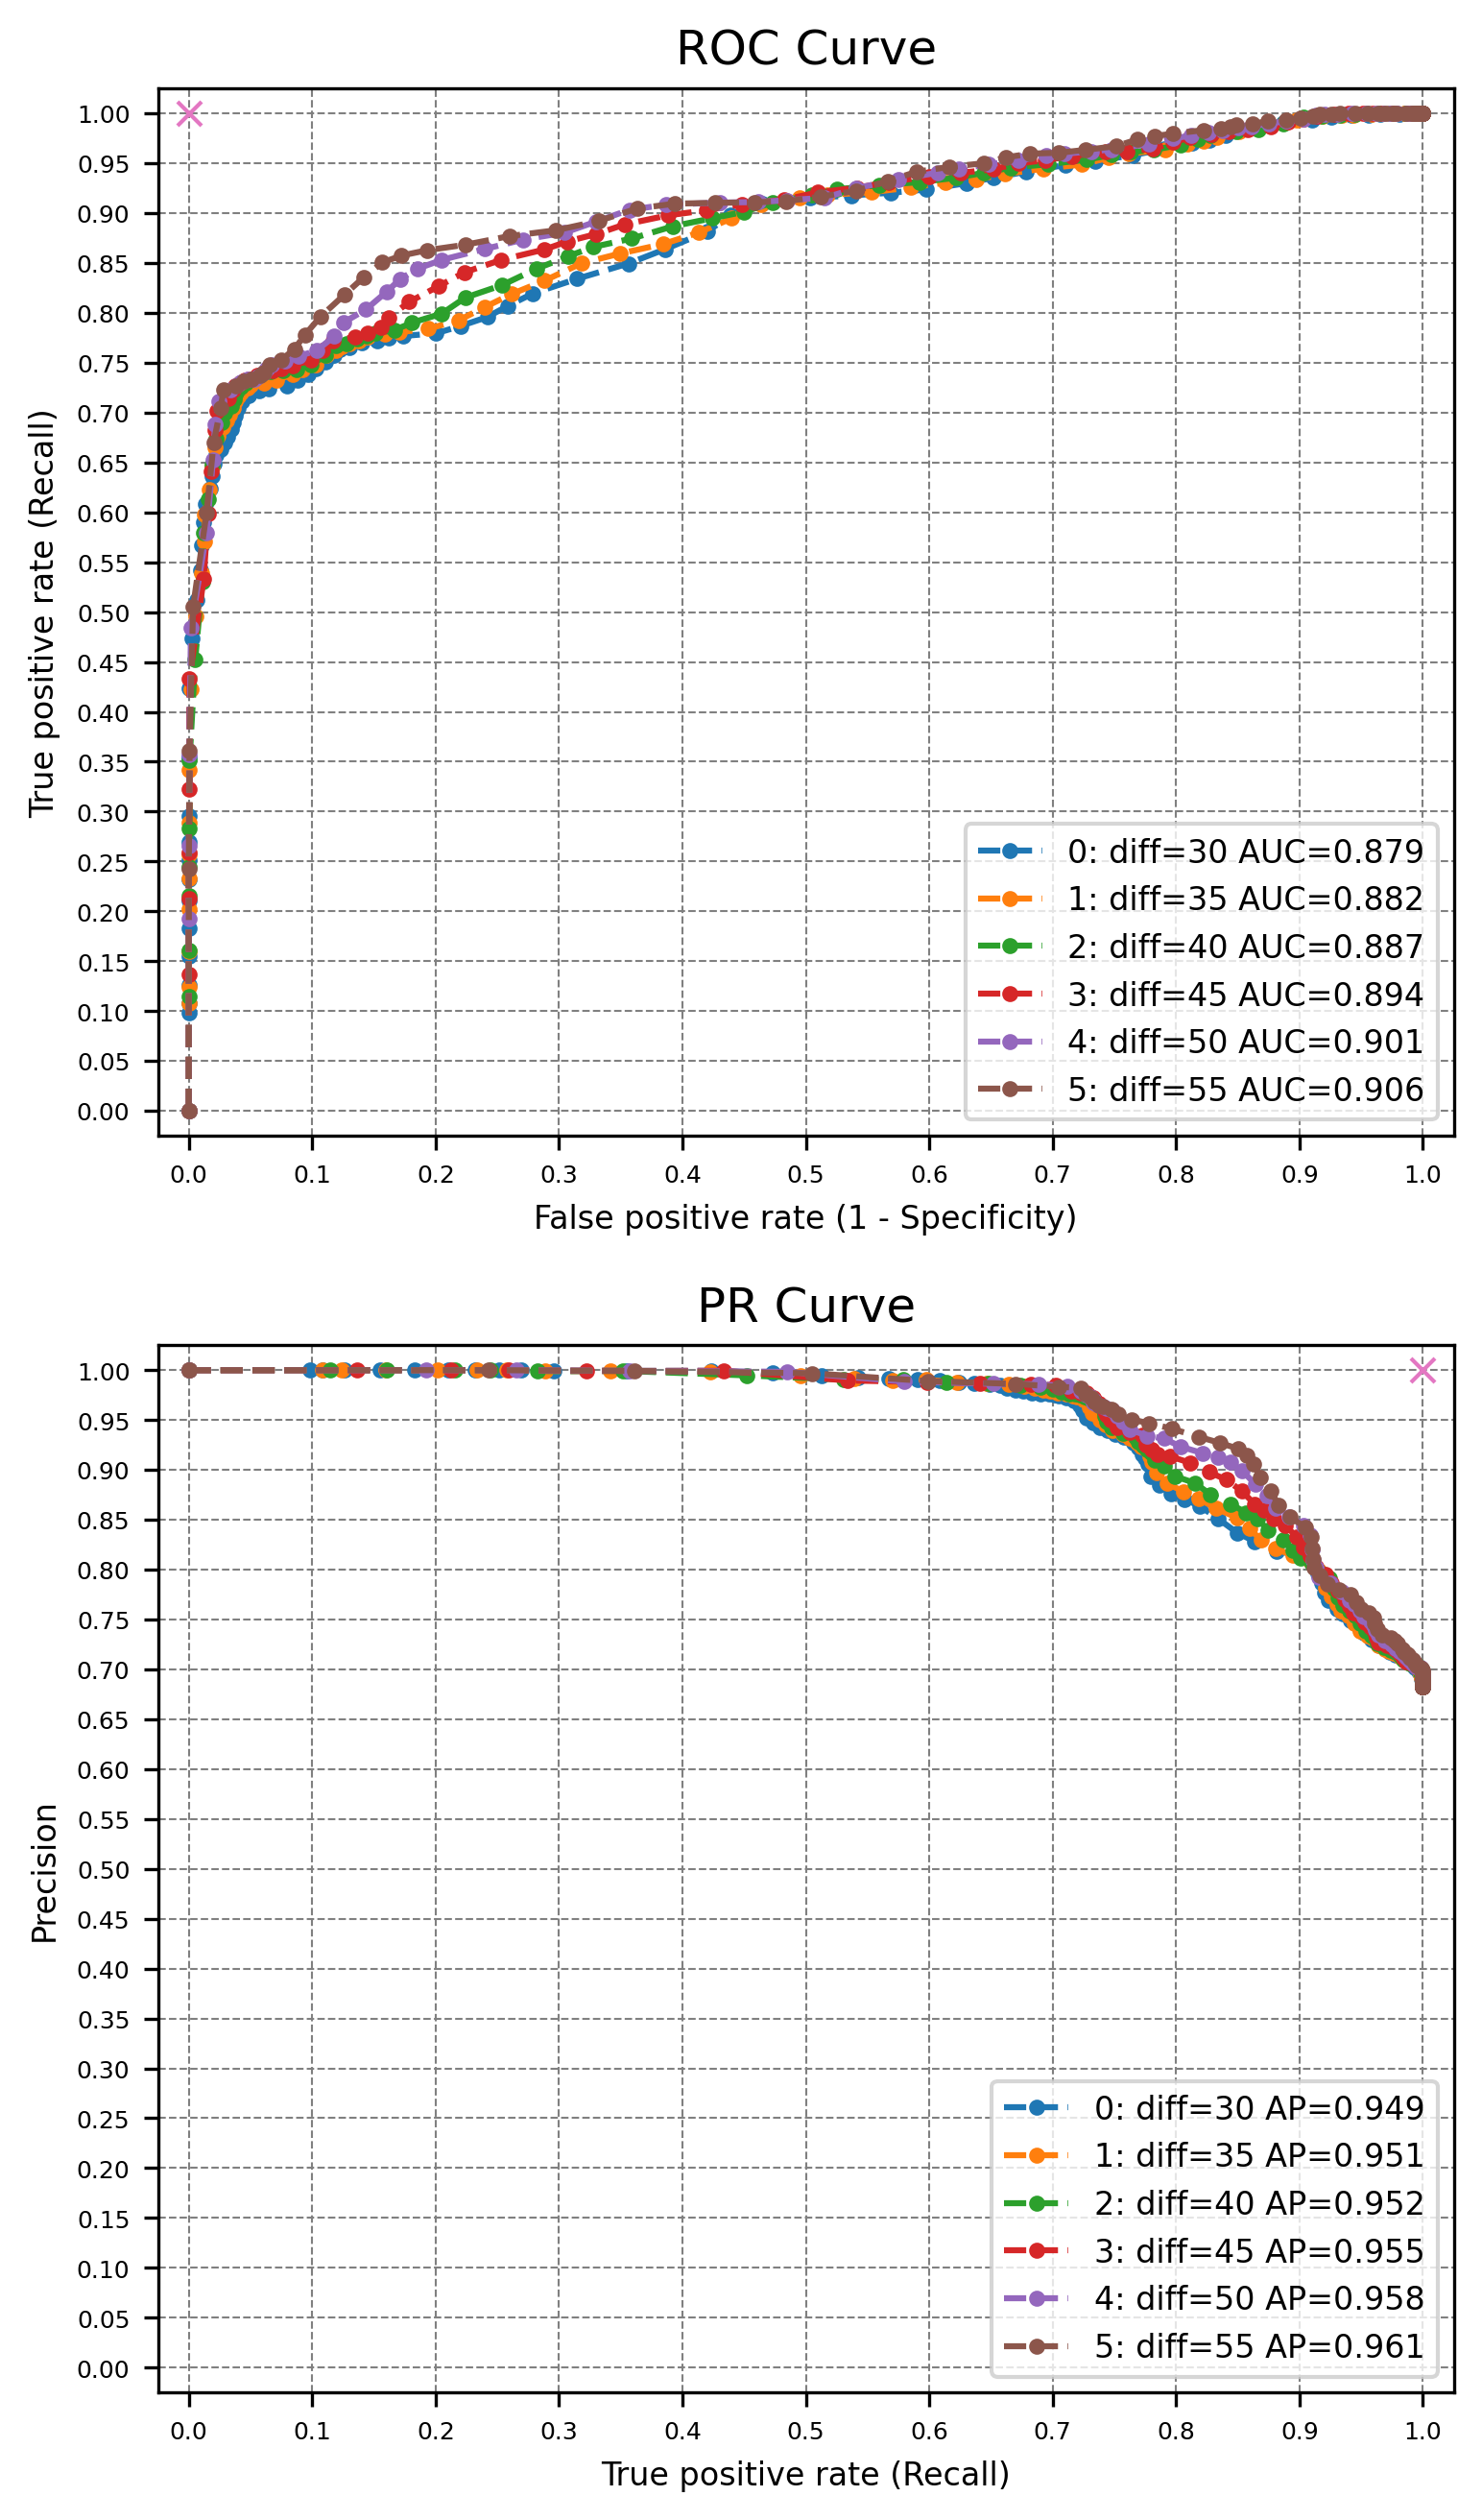

In [11]:
parking_id = 'UFPR04'
training_parking(parking_id)

### UFPR04 Training Choose Parameters

In [2]:
df = choose_training_parameters('UFPR04')

test/diffDetector/metrics_dict_vt_UFPR04_Sunny_training.pickle
test/diffDetector/metrics_dict_vt_UFPR04_Cloudy_training.pickle
test/diffDetector/metrics_dict_vt_UFPR04_Rainy_training.pickle
Training & Sunny & 55 & 0.18 & 0.884 & 0.913 & 0.854 & 0.869 & 0.887
Training & Sunny & 55 & 0.18 & 0.884 & 0.913 & 0.854 & 0.869 & 0.887
Training & Cloudy & 55 & 0.18 & 0.938 & 0.911 & 0.778 & 0.851 & 0.827
Training & Cloudy & 55 & 0.25 & 0.875 & 0.779 & 0.903 & 0.889 & 0.858
Training & Rainy & 55 & 0.18 & 0.933 & 0.874 & 0.819 & 0.872 & 0.836
Training & Rainy & 55 & 0.25 & 0.865 & 0.702 & 0.883 & 0.874 & 0.826


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    55  0.18  0.930        ROC  0.170      0.884        0.913   
1   Sunny    55  0.18  0.930         PR  0.187      0.884        0.913   
2  Cloudy    55  0.18  0.923        ROC  0.170      0.938        0.911   
3  Cloudy    55  0.25  0.923         PR  0.158      0.875        0.779   
4   Rainy    55  0.18  0.906        ROC  0.170      0.933        0.874   
5   Rainy    55  0.25  0.906         PR  0.158      0.865        0.702   

   Recall     F1  Accuracy  
0   0.854  0.869     0.887  
1   0.854  0.869     0.887  
2   0.778  0.851     0.827  
3   0.903  0.889     0.858  
4   0.819  0.872     0.836  
5   0.883  0.874     0.826

Mejor fila por weather:
  Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    55  0.18  0.930        ROC  0.170      0.884        0.913   
3  Cloudy    55  0.25  0.923         PR  0.158      0.875        0.779   
5   Rainy    55  0.25  0.906         PR  0.158      0.865        0.702   

   Recall     F1  Accuracy  
0   0.854  0.869     0.887  
3   0.903  0.889     0.858  
5   0.883  0.874     0.826  


### UFPR04 Testing

Sunny-Testing bs=55 vt=0.18
Using OccupancyDetectorDiff
Selected 429 files
Processing 429 files with 10 workers


  0%|          | 0/429 [00:00<?, ?it/s]

Precision: 0.893
specificity: 0.896
Recall: 0.878
F1 Score: 0.886
Accuracy: 0.887


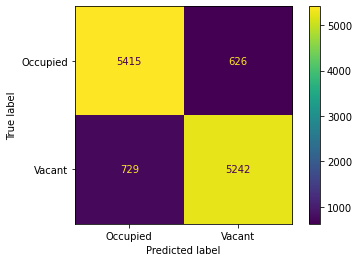

Test & Sunny & 55 & 0.18 & 0.893 & 0.896 & 0.878 & 0.886 & 0.887
Cloudy-Testing bs=55 vt=0.25
Using OccupancyDetectorDiff
Selected 288 files
Processing 288 files with 10 workers


  0%|          | 0/288 [00:00<?, ?it/s]

Precision: 0.918
specificity: 0.810
Recall: 0.903
F1 Score: 0.910
Accuracy: 0.875


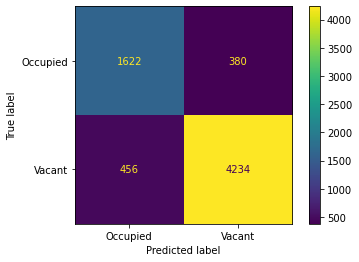

Test & Cloudy & 55 & 0.25 & 0.918 & 0.810 & 0.903 & 0.910 & 0.875
Rainy-Testing bs=55 vt=0.18
Using OccupancyDetectorDiff
Selected 61 files
Processing 61 files with 10 workers


  0%|          | 0/61 [00:00<?, ?it/s]

Precision: 0.889
specificity: 0.856
Recall: 0.871
F1 Score: 0.880
Accuracy: 0.865


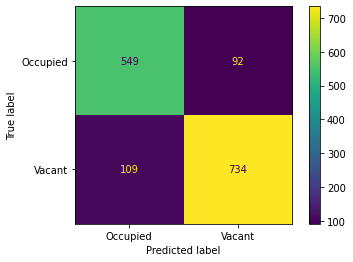

Test & Rainy & 55 & 0.18 & 0.889 & 0.856 & 0.871 & 0.880 & 0.865


In [3]:
test_parking_diff_vt('UFPR04',diff_threshold=55 ,vacant_threshold=0.18, weather_list=['Sunny'])
test_parking_diff_vt('UFPR04',diff_threshold=55 ,vacant_threshold=0.25, weather_list=['Cloudy'])
test_parking_diff_vt('UFPR04',diff_threshold=55 ,vacant_threshold=0.18, weather_list=['Rainy'])

## UFPR05

### UPFR05 Training

test/diffDetector/metrics_dict_vt_UFPR05_Sunny_training.pickle


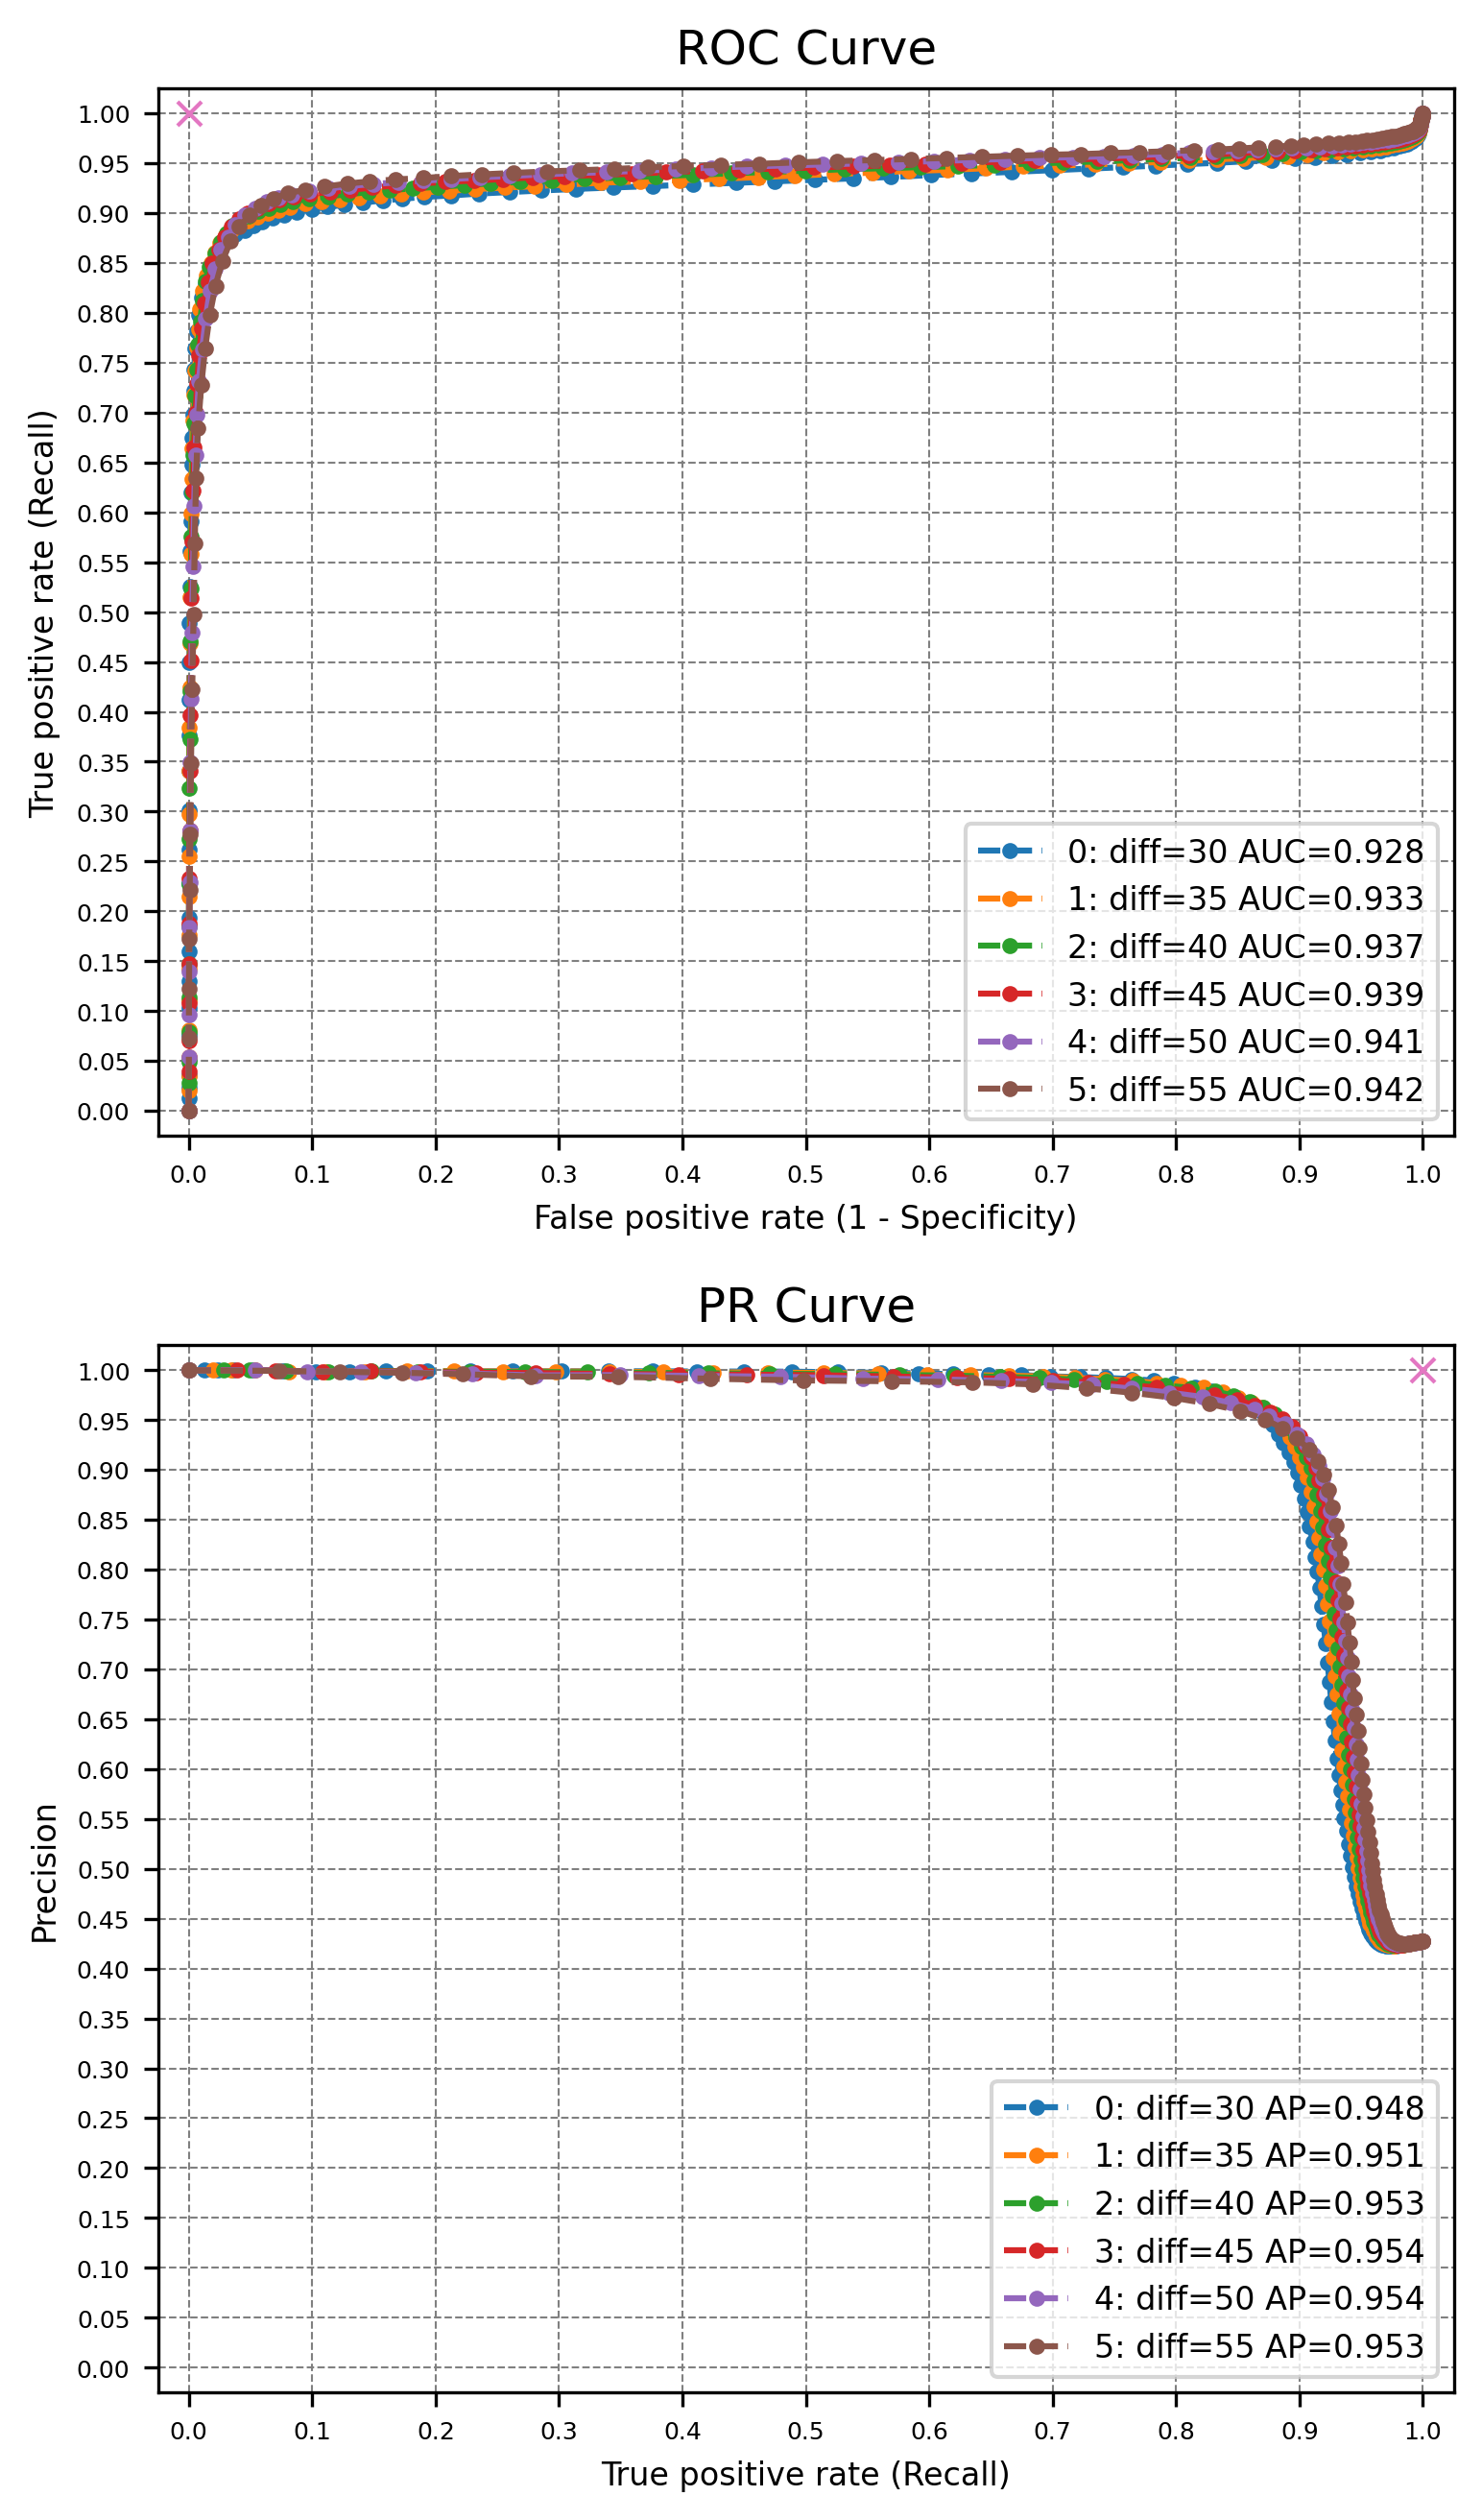

Testing  Training UFPR05-Cloudy diff=30
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:35<00:00, 31.65it/s]


Testing  Training UFPR05-Cloudy diff=35
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:36<00:00, 31.25it/s]


Testing  Training UFPR05-Cloudy diff=40
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:36<00:00, 31.13it/s]


Testing  Training UFPR05-Cloudy diff=45
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:37<00:00, 30.61it/s]


Testing  Training UFPR05-Cloudy diff=50
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:36<00:00, 31.07it/s]


Testing  Training UFPR05-Cloudy diff=55
Using OccupancyDetectorDiff
Selected 1133 files
Processing 1133 files with 10 workers


100%|██████████| 1133/1133 [00:36<00:00, 31.47it/s]


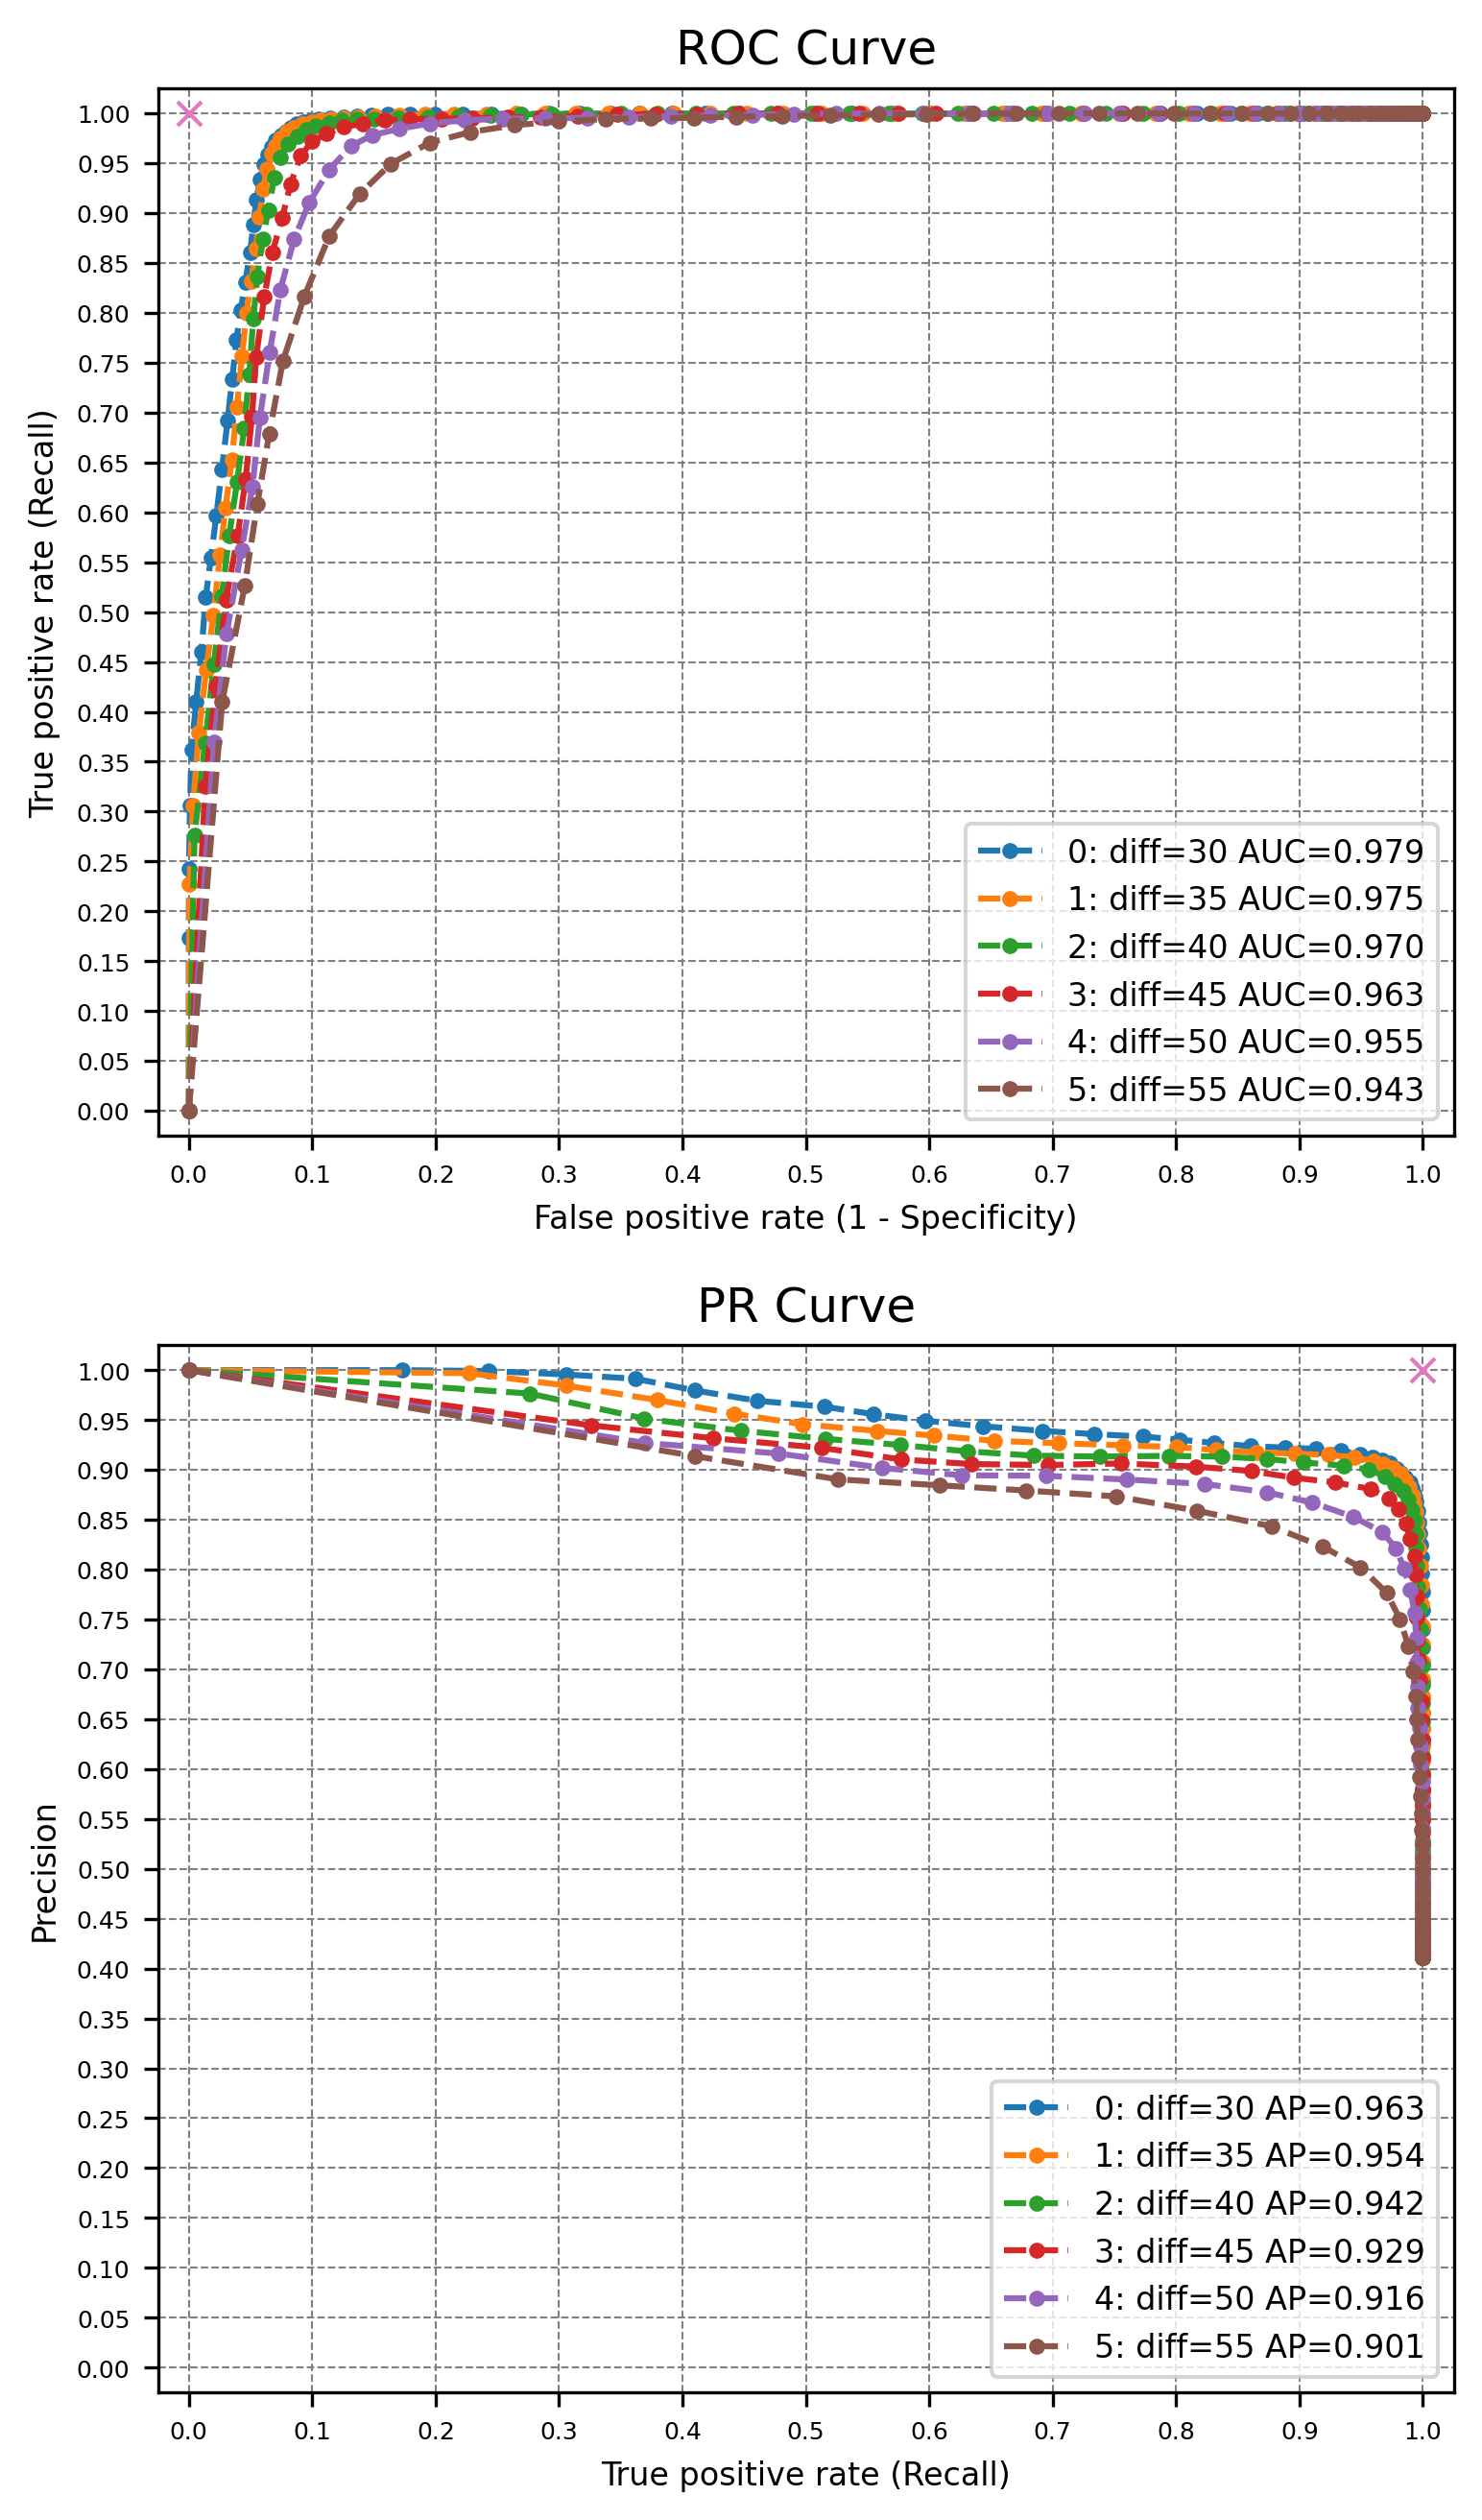

test/diffDetector/metrics_dict_vt_UFPR05_Rainy_training.pickle


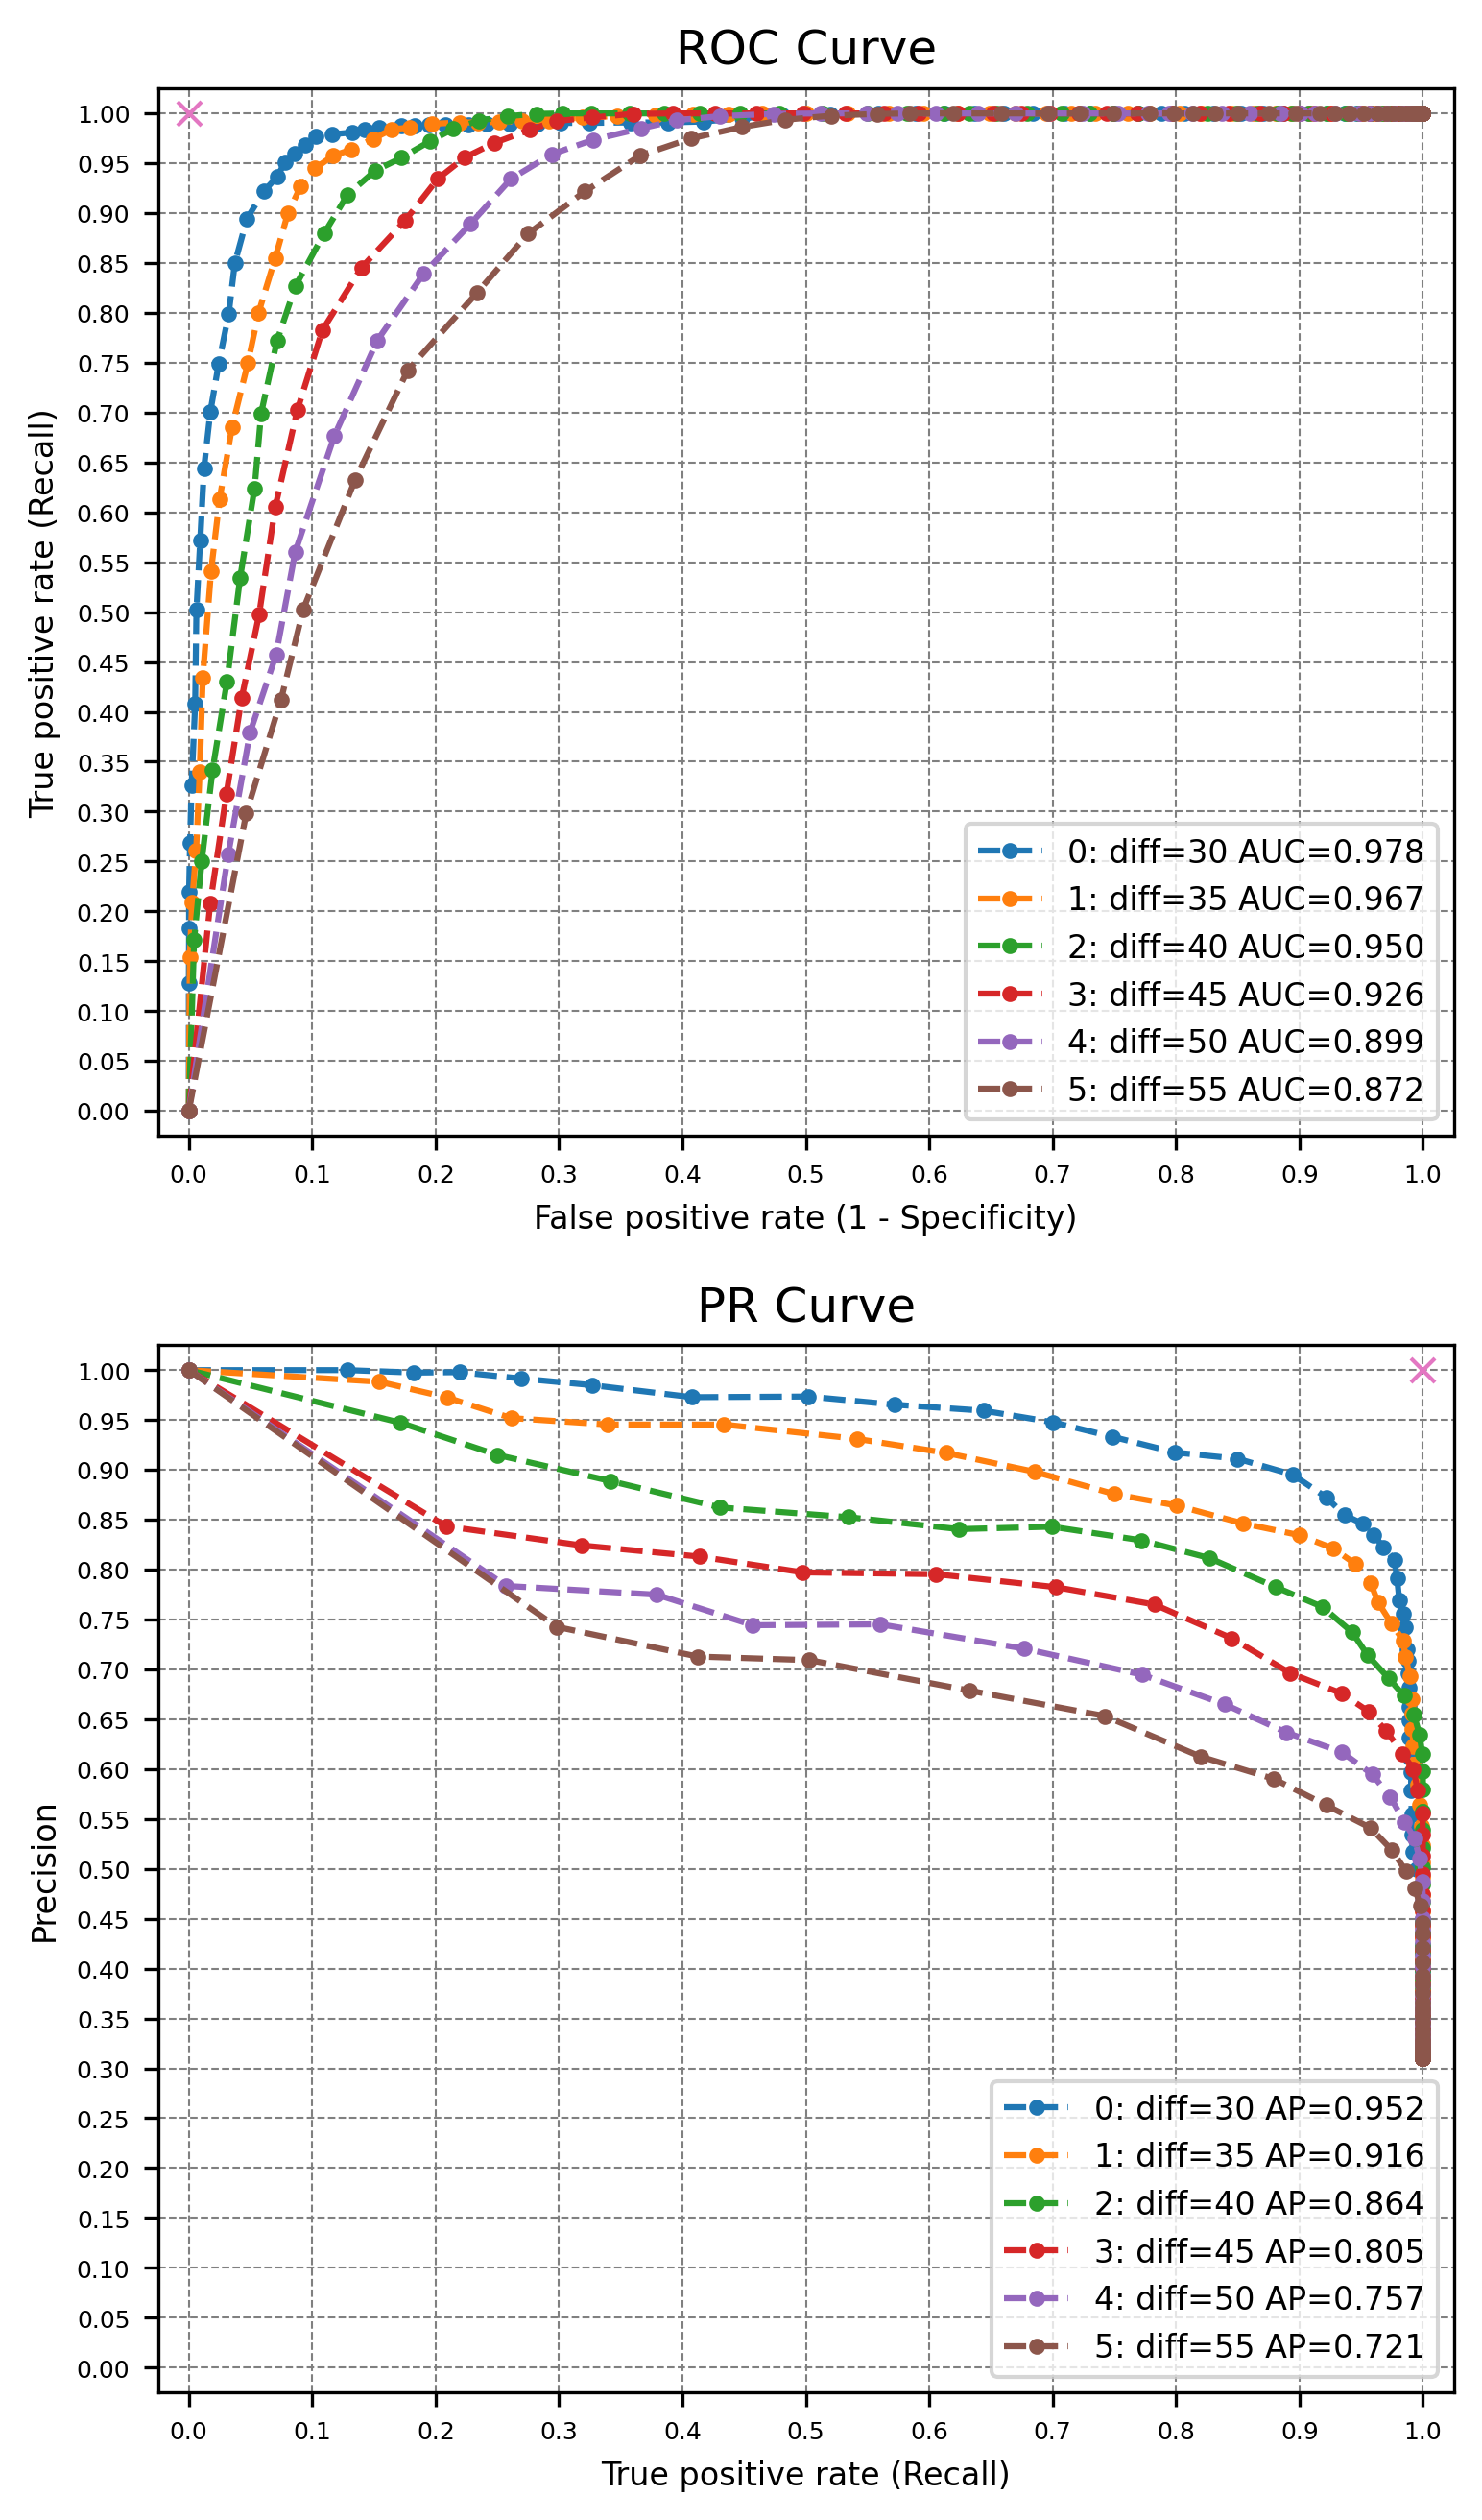

In [12]:
parking_id = 'UFPR05'
training_parking(parking_id)

### UFPR05 Training Choose Parameters

In [4]:
parking_id = 'UFPR05'
choose_training_parameters(parking_id)

test/diffDetector/metrics_dict_vt_UFPR05_Sunny_training.pickle
test/diffDetector/metrics_dict_vt_UFPR05_Cloudy_training.pickle
test/diffDetector/metrics_dict_vt_UFPR05_Rainy_training.pickle
Training & Sunny & 55 & 0.21 & 0.909 & 0.932 & 0.915 & 0.912 & 0.924
Training & Sunny & 55 & 0.2 & 0.921 & 0.942 & 0.907 & 0.914 & 0.927
Training & Cloudy & 30 & 0.22 & 0.910 & 0.933 & 0.967 & 0.938 & 0.947
Training & Cloudy & 30 & 0.22 & 0.910 & 0.933 & 0.967 & 0.938 & 0.947
Training & Rainy & 30 & 0.22 & 0.769 & 0.867 & 0.981 & 0.862 & 0.903
Training & Rainy & 30 & 0.22 & 0.769 & 0.867 & 0.981 & 0.862 & 0.903


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    55  0.21  0.942        ROC  0.109      0.909        0.932   
1   Sunny    55  0.20  0.942         PR  0.122      0.921        0.942   
2  Cloudy    30  0.22  0.979        ROC  0.075      0.910        0.933   
3  Cloudy    30  0.22  0.979         PR  0.096      0.910        0.933   
4   Rainy    30  0.22  0.978        ROC  0.075      0.769        0.867   
5   Rainy    30  0.22  0.978         PR  0.096      0.769        0.867   

   Recall     F1  Accuracy  
0   0.915  0.912     0.924  
1   0.908  0.914     0.927  
2   0.967  0.938     0.947  
3   0.967  0.938     0.947  
4   0.981  0.862     0.903  
5   0.981  0.862     0.903

Mejor fila por weather:
  Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
1   Sunny    55  0.20  0.942         PR  0.122      0.921        0.942   
2  Cloudy    30  0.22  0.979        ROC  0.075      0.910        0.933   
4   Rainy    30  0.22  0.978        ROC  0.075      0.769        0.867   

   Recall     F1  Accuracy  
1   0.908  0.914     0.927  
2   0.967  0.938     0.947  
4   0.981  0.862     0.903  


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    55  0.21  0.942        ROC  0.109      0.909        0.932   
1   Sunny    55  0.20  0.942         PR  0.122      0.921        0.942   
2  Cloudy    30  0.22  0.979        ROC  0.075      0.910        0.933   
3  Cloudy    30  0.22  0.979         PR  0.096      0.910        0.933   
4   Rainy    30  0.22  0.978        ROC  0.075      0.769        0.867   
5   Rainy    30  0.22  0.978         PR  0.096      0.769        0.867   

   Recall     F1  Accuracy  
0   0.915  0.912     0.924  
1   0.908  0.914     0.927  
2   0.967  0.938     0.947  
3   0.967  0.938     0.947  
4   0.981  0.862     0.903  
5   0.981  0.862     0.903

### UFPR05 Testing

Sunny-Testing bs=55 vt=0.2
Using OccupancyDetectorDiff
Selected 511 files
Processing 511 files with 10 workers


100%|██████████| 511/511 [00:17<00:00, 29.76it/s]

Precision: 0.905
specificity: 0.934
Recall: 0.918
F1 Score: 0.911
Accuracy: 0.928


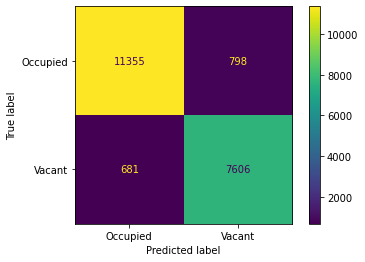

Test & Sunny & 55 & 0.2 & 0.905 & 0.934 & 0.918 & 0.911 & 0.928
Cloudy-Testing bs=30 vt=0.22
Using OccupancyDetectorDiff
Selected 293 files
Processing 293 files with 10 workers


100%|██████████| 293/293 [00:10<00:00, 27.74it/s]

Precision: 0.908
specificity: 0.937
Recall: 0.981
F1 Score: 0.943
Accuracy: 0.954


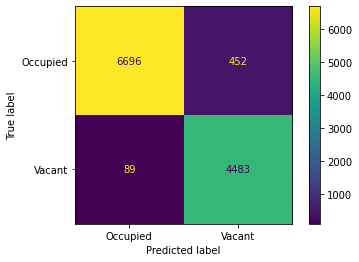

Test & Cloudy & 30 & 0.22 & 0.908 & 0.937 & 0.981 & 0.943 & 0.954
Rainy-Testing bs=30 vt=0.22
Using OccupancyDetectorDiff
Selected 49 files
Processing 49 files with 10 workers


100%|██████████| 49/49 [00:03<00:00, 13.37it/s]

Precision: 0.803
specificity: 0.880
Recall: 0.980
F1 Score: 0.883
Accuracy: 0.913


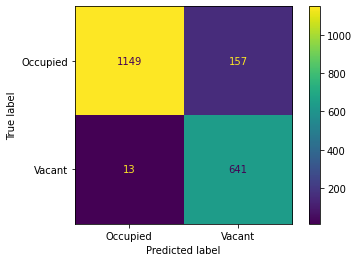

Test & Rainy & 30 & 0.22 & 0.803 & 0.880 & 0.980 & 0.883 & 0.913


In [8]:
test_parking_diff_vt('UFPR05',diff_threshold=55 ,vacant_threshold=0.20, weather_list=['Sunny'])
test_parking_diff_vt('UFPR05',diff_threshold=30 ,vacant_threshold=0.22, weather_list=['Cloudy'])
test_parking_diff_vt('UFPR05',diff_threshold=30 ,vacant_threshold=0.22, weather_list=['Rainy'])

## PUCPR

### PUCPR Training

test/diffDetector/metrics_dict_vt_PUCPR_Sunny_training.pickle


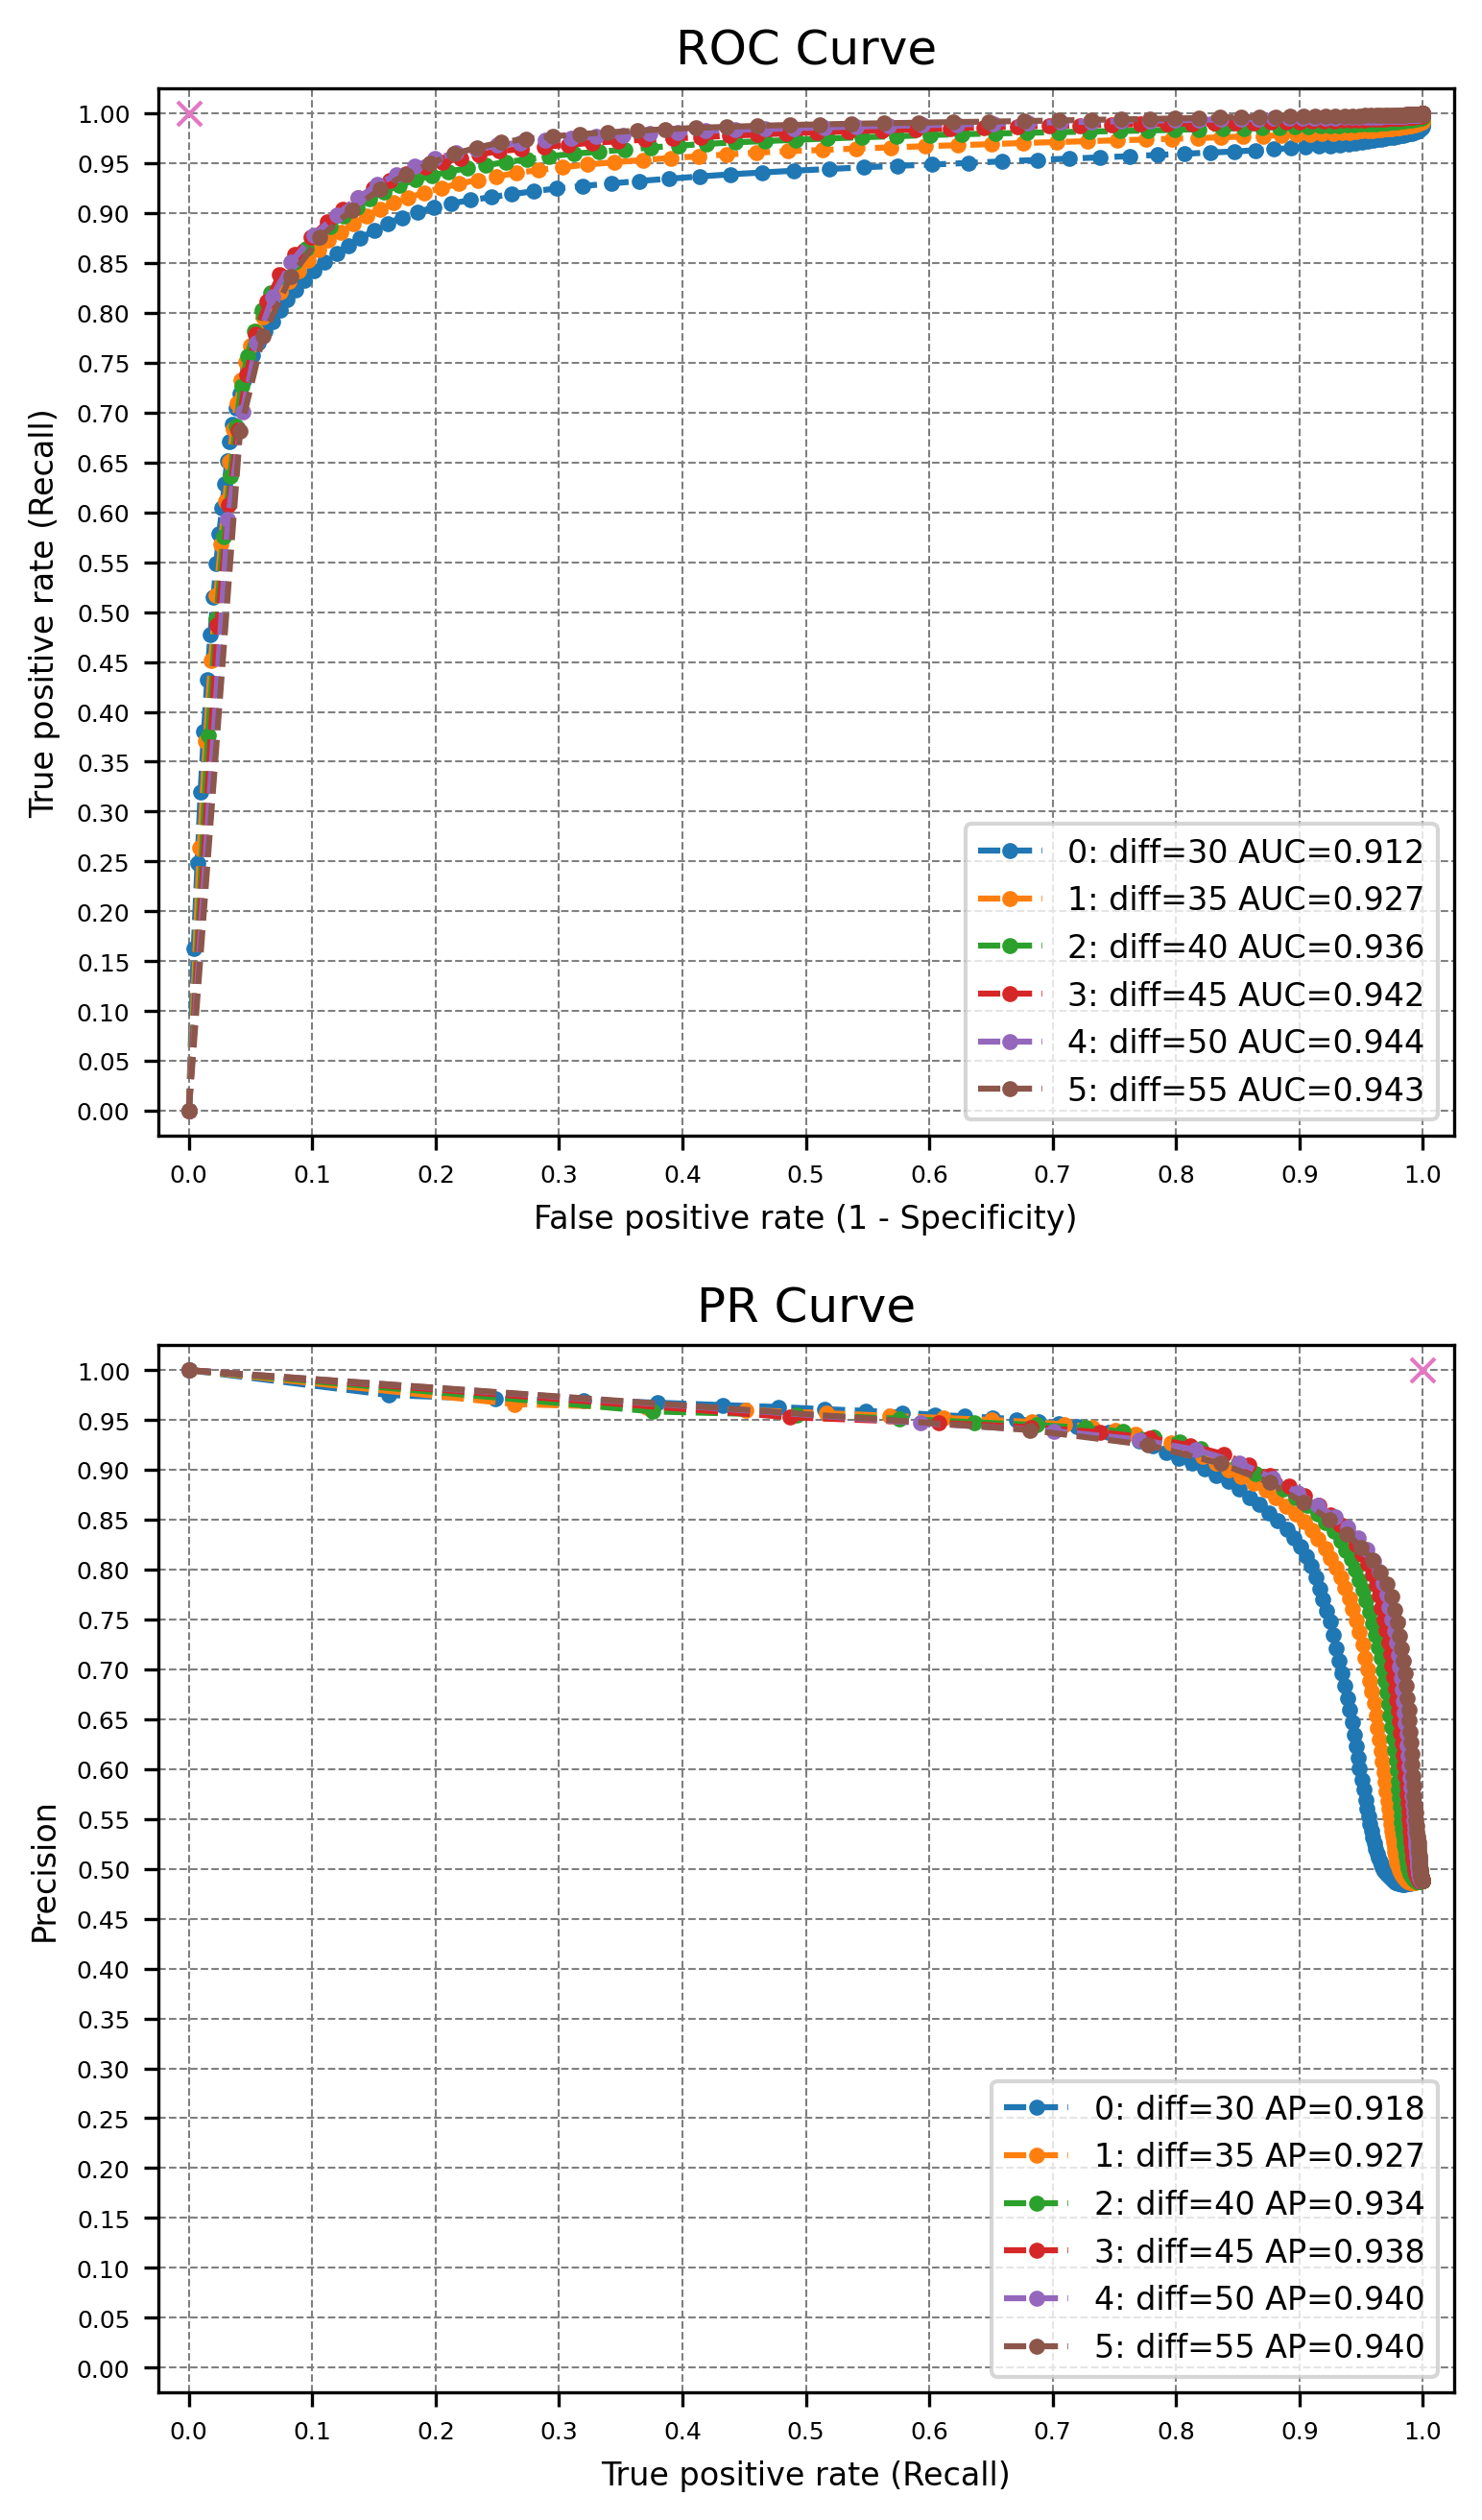

test/diffDetector/metrics_dict_vt_PUCPR_Cloudy_training.pickle


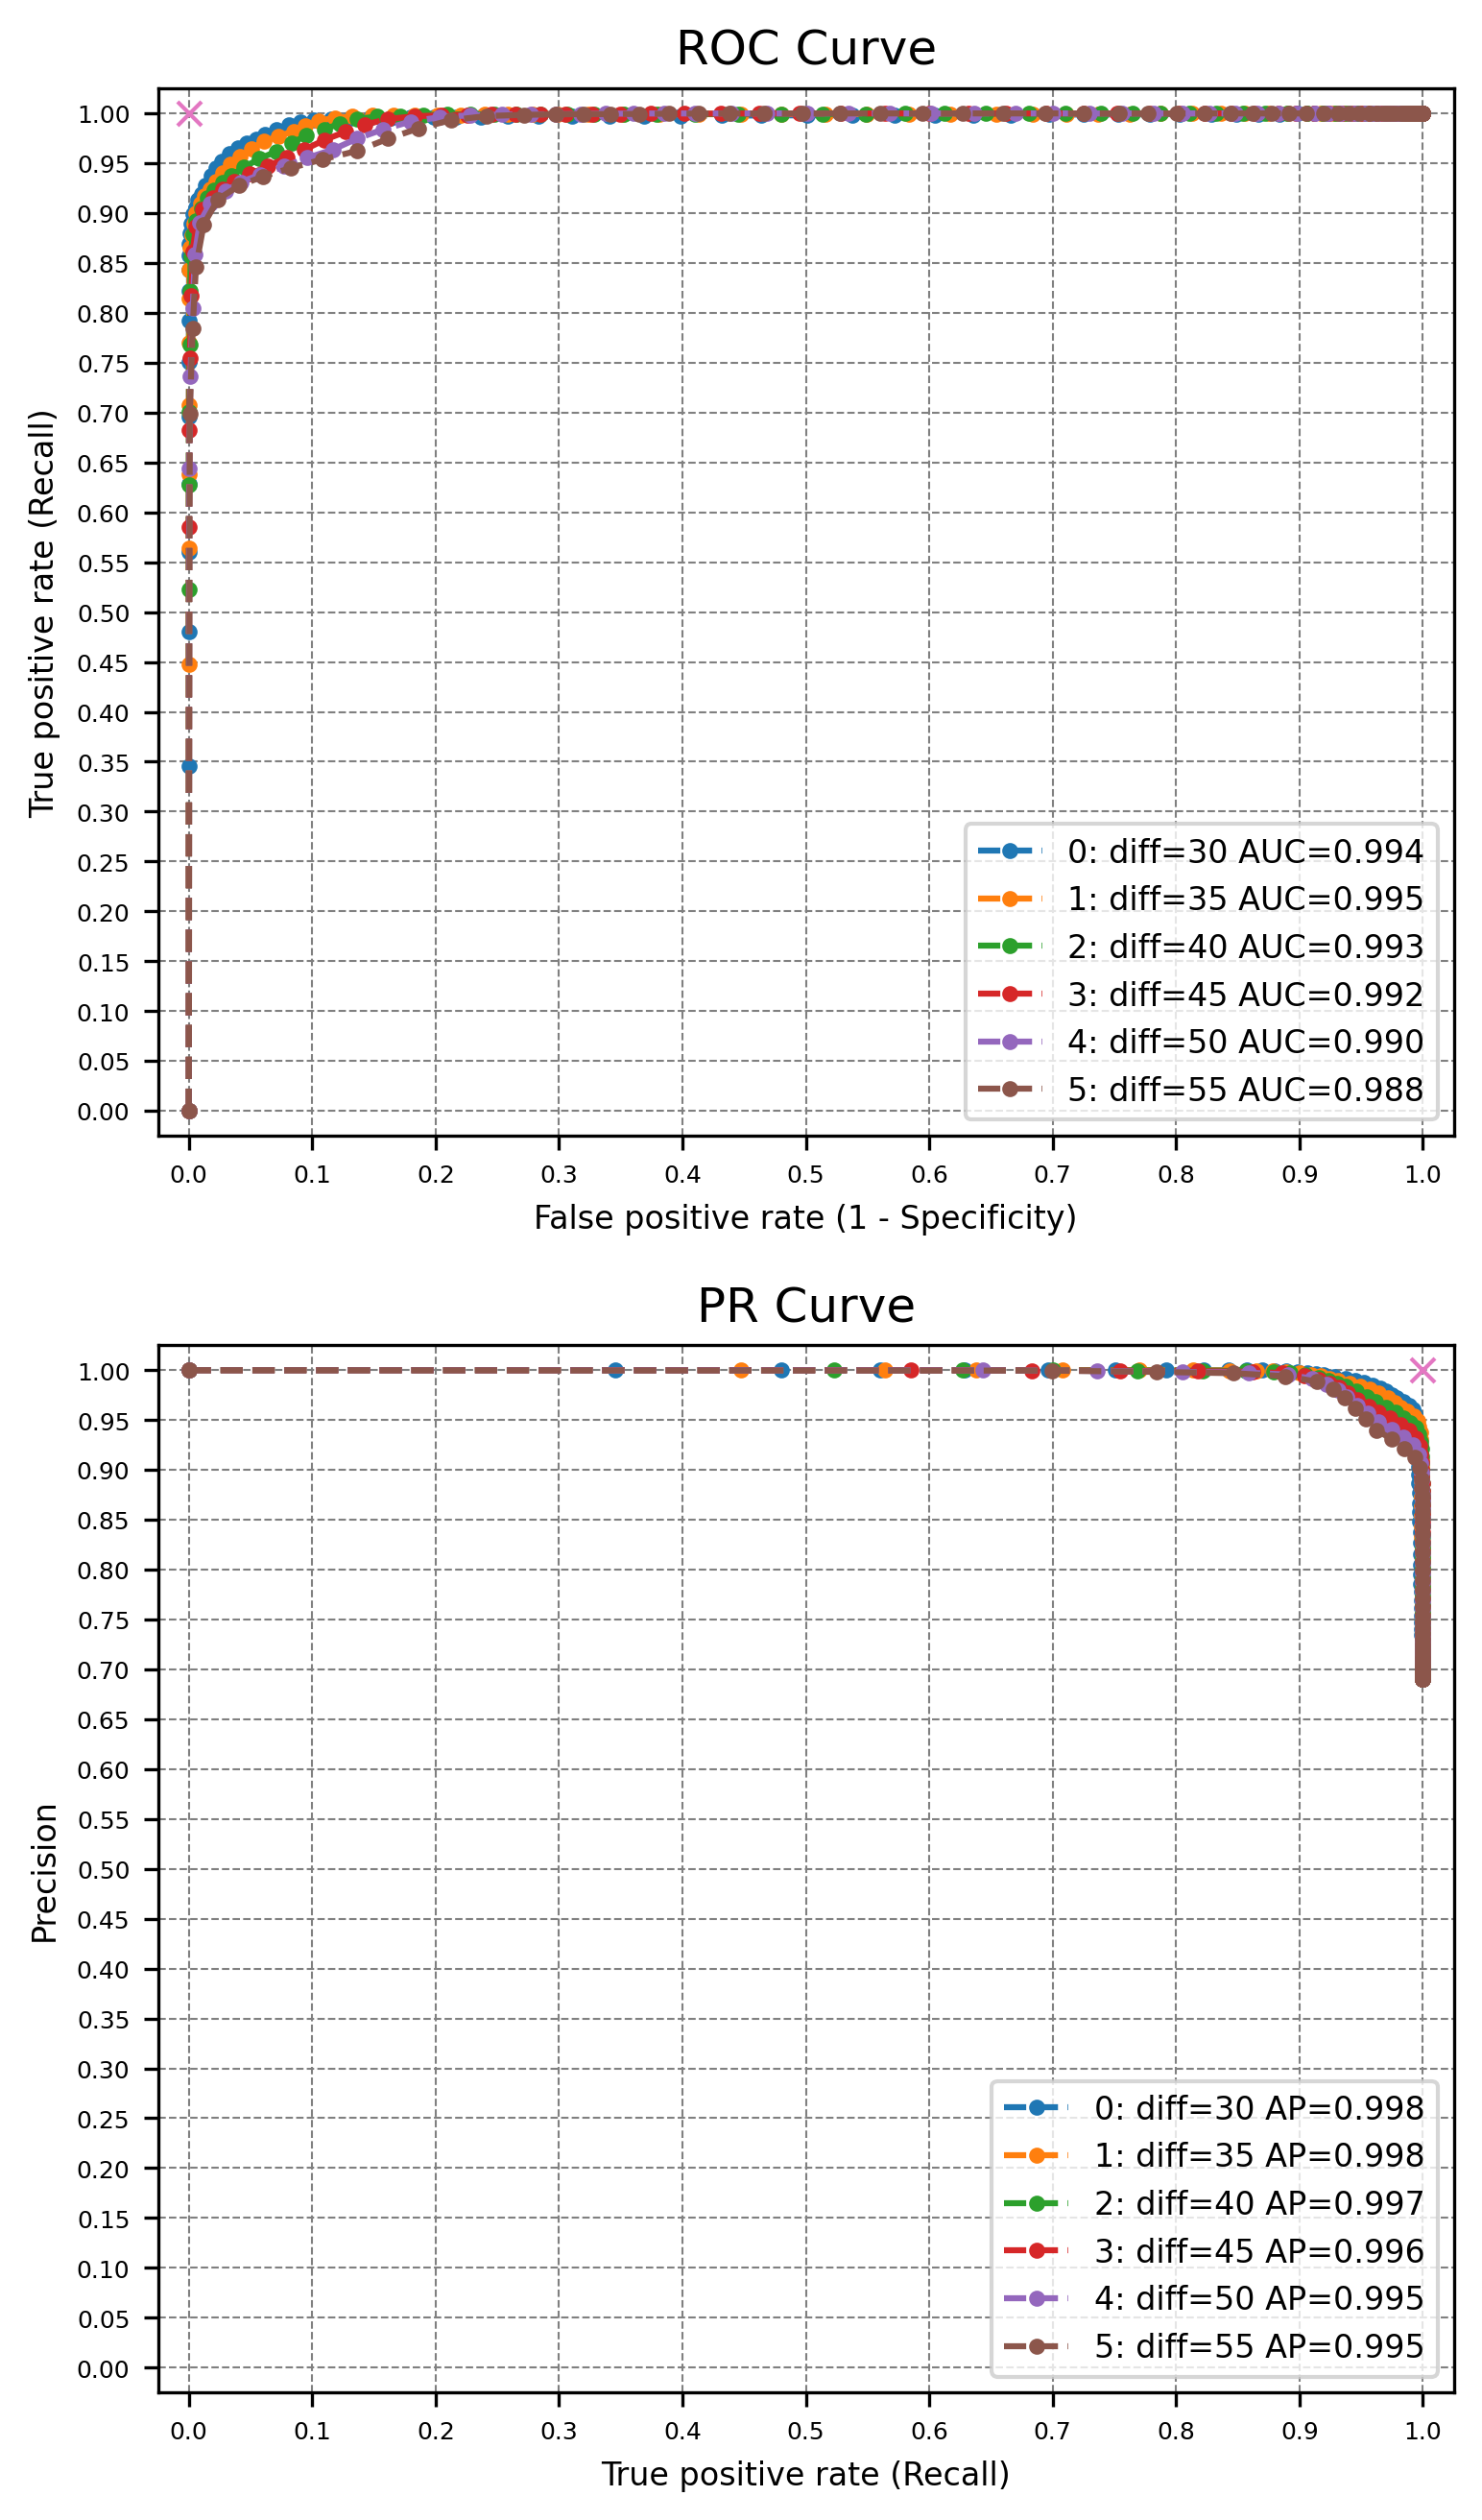

test/diffDetector/metrics_dict_vt_PUCPR_Rainy_training.pickle


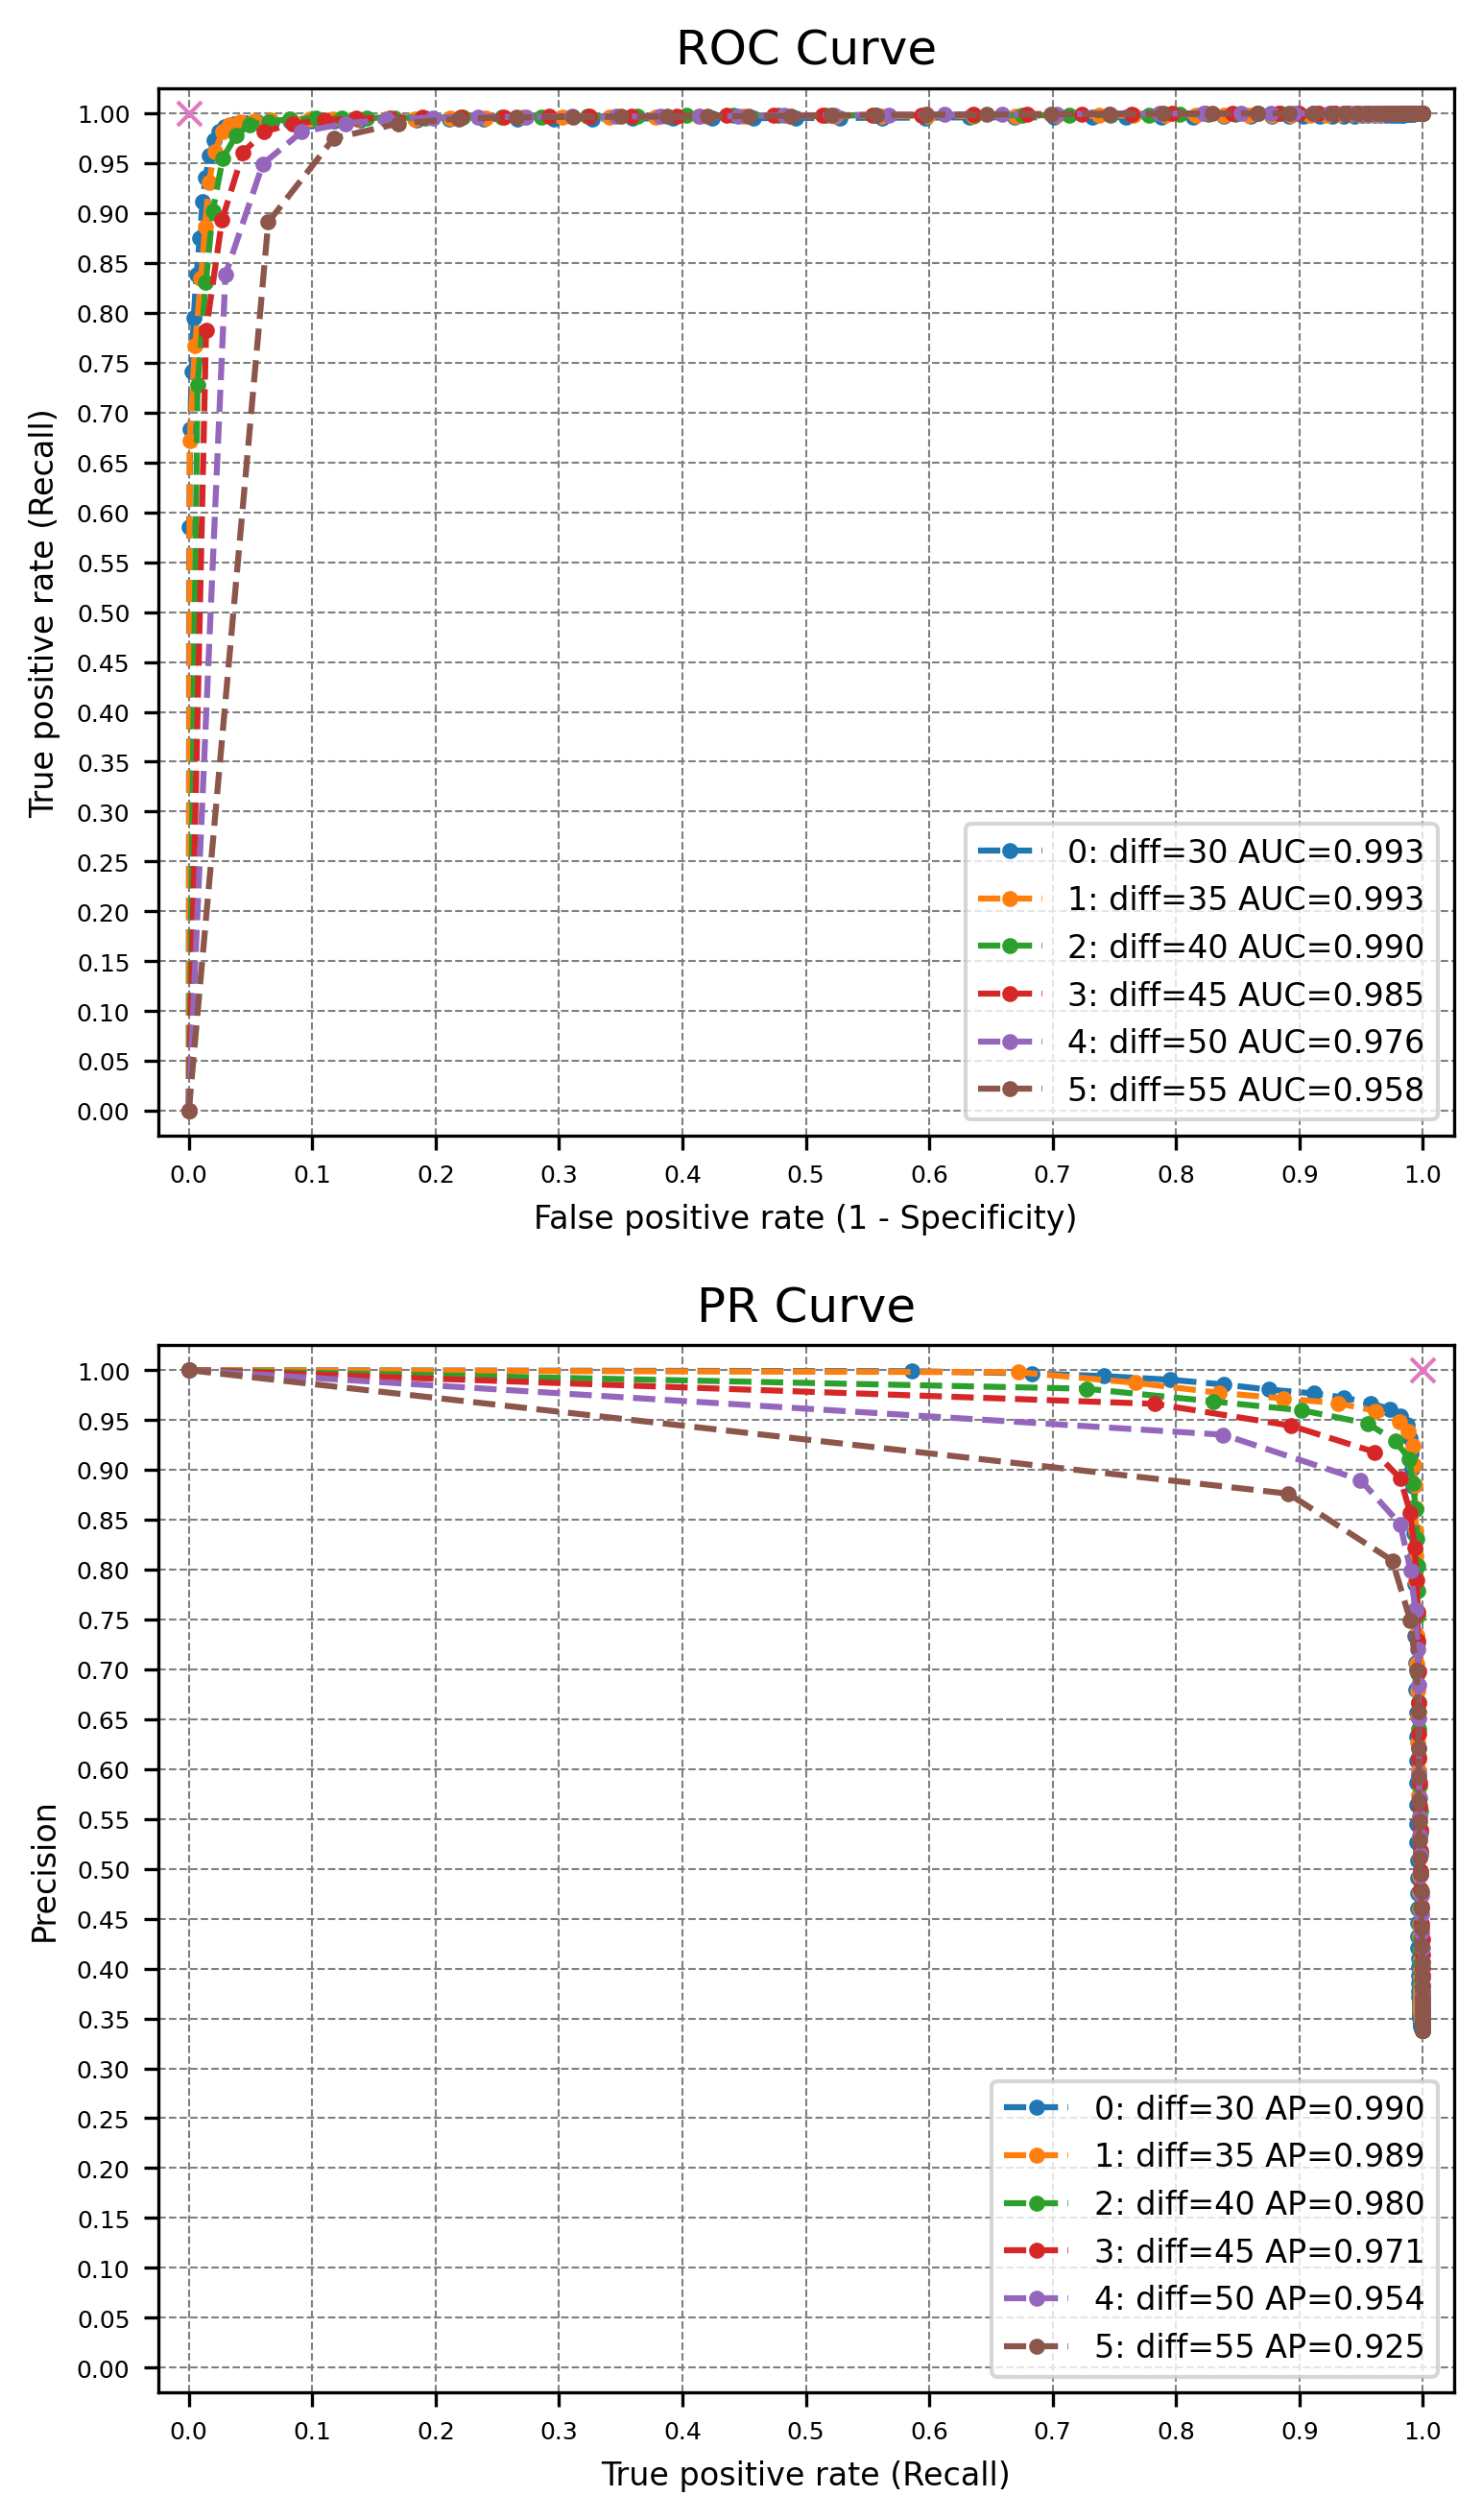

In [6]:
parking_id = 'PUCPR'
training_parking(parking_id)

### PUCPR Training Choose Parameters

In [6]:
parking_id = 'PUCPR'
df = choose_training_parameters(parking_id)
print(df.to_latex())

test/diffDetector/metrics_dict_vt_PUCPR_Sunny_training.pickle
test/diffDetector/metrics_dict_vt_PUCPR_Cloudy_training.pickle
test/diffDetector/metrics_dict_vt_PUCPR_Rainy_training.pickle
Training & Sunny & 50 & 0.07 & 0.877 & 0.880 & 0.898 & 0.888 & 0.889
Training & Sunny & 50 & 0.07 & 0.877 & 0.880 & 0.898 & 0.888 & 0.889
Training & Cloudy & 35 & 0.18 & 0.981 & 0.959 & 0.956 & 0.969 & 0.957
Training & Cloudy & 35 & 0.2 & 0.973 & 0.939 & 0.972 & 0.972 & 0.962
Training & Rainy & 35 & 0.07 & 0.948 & 0.973 & 0.981 & 0.965 & 0.976
Training & Rainy & 35 & 0.2 & 0.652 & 0.729 & 0.996 & 0.788 & 0.819


Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    50  0.07  0.944        ROC  0.157      0.877        0.880   
1   Sunny    50  0.07  0.944         PR  0.159      0.877        0.880   
2  Cloudy    35  0.18  0.995        ROC  0.060      0.981        0.959   
3  Cloudy    35  0.20  0.995         PR  0.039      0.973        0.939   
4   Rainy    35  0.07  0.993        ROC  0.033      0.948        0.973   
5   Rainy    35  0.20  0.993         PR  0.039      0.652        0.729   

   Recall     F1  Accuracy  
0   0.898  0.888     0.889  
1   0.898  0.888     0.889  
2   0.956  0.969     0.957  
3   0.972  0.972     0.962  
4   0.981  0.965     0.976  
5   0.996  0.788     0.819

Mejor fila por weather:
  Weather  diff    vt    AUC Dist Curve   Dist  Precision  Specificity  \
0   Sunny    50  0.07  0.944        ROC  0.157      0.877        0.880   
3  Cloudy    35  0.20  0.995         PR  0.039      0.973        0.939   
4   Rainy    35  0.07  0.993        ROC  0.033      0.948        0.973   

   Recall     F1  Accuracy  
0   0.898  0.888     0.889  
3   0.972  0.972     0.962  
4   0.981  0.965     0.976  
\begin{tabular}{llrrrlrrrrrr}
\toprule
{} & Weather &  diff &    vt &    AUC & Dist Curve &   Dist &  Precision &  Specificity &  Recall &     F1 &  Accuracy \\
\midrule
0 &   Sunny &    50 &  0.07 &  0.944 &        ROC &  0.157 &      0.877 &        0.880 &   0.898 &  0.888 &     0.889 \\
1 &   Sunny &    50 &  0.07 &  0.944 &         PR &  0.159 &      0.877 &        0.880 &   0.898 &  0.888 &     0.889 \\
2 &  Cloudy &    35 &  0.18 &  0.995 &        ROC &  0.060 &      0.981 &        0.959 &   0.956 &  0.969 &     0.957 \\
3 &  Cloudy &    35 &  0.20 & 

### PUCPR Testing

Sunny-Testing bs=50 vt=0.07
Using OccupancyDetectorDiff
Selected 471 files
Processing 471 files with 10 workers


100%|██████████| 471/471 [00:15<00:00, 29.58it/s]


Precision: 0.866
specificity: 0.882
Recall: 0.908
F1 Score: 0.886
Accuracy: 0.894


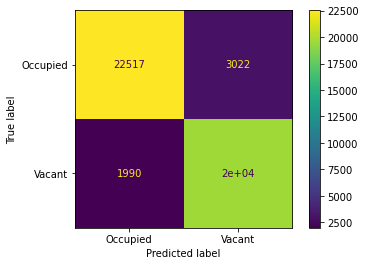

Test & Sunny & 50 & 0.07 & 0.866 & 0.882 & 0.908 & 0.886 & 0.894
Cloudy-Testing bs=35 vt=0.3
Using OccupancyDetectorDiff
Selected 269 files
Processing 269 files with 10 workers


100%|██████████| 269/269 [00:10<00:00, 25.53it/s]


Precision: 0.894
specificity: 0.785
Recall: 0.999
F1 Score: 0.943
Accuracy: 0.923


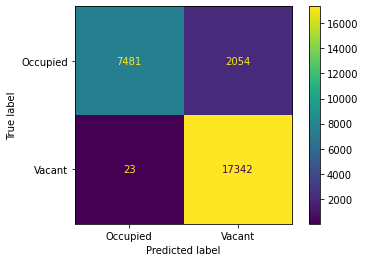

Test & Cloudy & 35 & 0.3 & 0.894 & 0.785 & 0.999 & 0.943 & 0.923
Rainy-Testing bs=35 vt=0.07
Using OccupancyDetectorDiff
Selected 169 files
Processing 169 files with 10 workers


100%|██████████| 169/169 [00:07<00:00, 23.03it/s]

Precision: 0.932
specificity: 0.966
Recall: 0.966
F1 Score: 0.949
Accuracy: 0.966


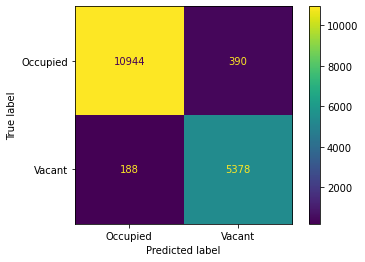

Test & Rainy & 35 & 0.07 & 0.932 & 0.966 & 0.966 & 0.949 & 0.966


In [9]:
test_parking_diff_vt('PUCPR',diff_threshold=50 ,vacant_threshold=0.07, weather_list=['Sunny'])
test_parking_diff_vt('PUCPR',diff_threshold=35 ,vacant_threshold=0.30, weather_list=['Cloudy'])
test_parking_diff_vt('PUCPR',diff_threshold=35 ,vacant_threshold=0.07, weather_list=['Rainy'])

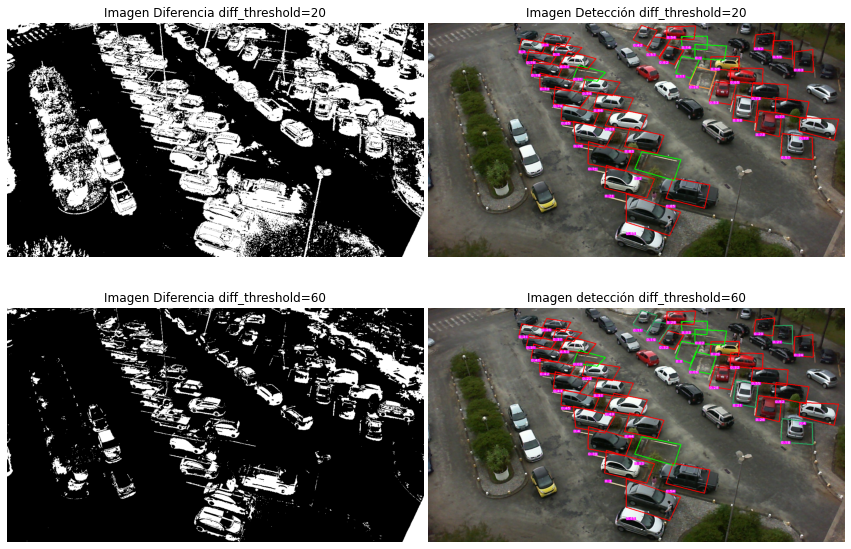

In [ ]:
import matplotlib.pyplot as plt
import cv2

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

plt.subplots_adjust(wspace=0.01, hspace=0.1)

ax1.imshow(cv2.cvtColor(cv2.imread('img_diff_threshold_20.png'), cv2.COLOR_BGR2RGB))
ax1.set_title('Imagen Diferencia diff_threshold=20', fontsize=12)
ax1.axis('off')

ax2.imshow(cv2.cvtColor(cv2.imread('img_detection_20.png'), cv2.COLOR_BGR2RGB))
ax2.set_title('Imagen Detección diff_threshold=20', fontsize=12)
ax2.axis('off')

ax3.imshow(cv2.imread('img_diff_threshold_60.png'))
ax3.set_title('Imagen Diferencia diff_threshold=60', fontsize=12)
ax3.axis('off')

ax4.imshow(cv2.cvtColor(cv2.imread('img_detection_60.png'), cv2.COLOR_BGR2RGB))
ax4.set_title('Imagen detección diff_threshold=60', fontsize=12)
ax4.axis('off')

plt.show()
